In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_znorm_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_znorm_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_znorm_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 12:30:35 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:30:35 pyobsbox.generator INFO: shuffle: True
Feb/23 12:30:35 pyobsbox.generator INFO: batch_size: 8192
Feb/23 12:30:35 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 12:30:35 pyobsbox.generator INFO: n_bunches: 256
Feb/23 12:30:35 pyobsbox.generator INFO: __len__: 1038
Feb/23 12:30:35 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 12:30:35 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 12:30:35 pyobsbox.generator INFO: normalization: znorm
Feb/23 12:30:35 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 12:30:35 pyobsbox.generator INFO: normalization_kwargs: {}
Feb/23 12:30:35 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:30:35 pyobsbox.generator INFO: shuffle: True
Feb/23 12:30:35 pyobsbox.generator INFO: batch

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265728, 11)


type  fill  beam plane  q           date_time  \
7245811  Inst  6581     1     h  7 2018-04-20 17:22:14   
6889221  Inst  7453     1     h  7 2018-11-18 06:39:21   
1617608  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141551  Inst  7466     1     h  7 2018-11-22 20:57:15   
593754   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245811  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6581/...         84   
6889221  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...        480   
1617608  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141551  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/...        670   
593754   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245811        156.0          66.0      65536  
6889221        449.0          79.0      65536  
1617608       1629.0        1197.0      65536  
6141551       2085.0         439.0      65536  
593754        2461.0        1361.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
6288790  Inst  6436     1     h  7 2017-11-30 05:39:49   
3580569  Inst  6337     1     h  7 2017-10-27 10:11:15   
3178141  Inst  7101     1     h  7 2018-08-30 01:49:14   
2269278  Inst  6696     1     h  7 2018-05-18 07:16:14   
709274   Inst  6255     1     h  7 2017-09-29 11:44:15   

                                                      file  n_bunches  \
6288790  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/...        408   
3580569  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6337/...       1868   
3178141  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7101/...       2556   
2269278  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/...       2556   
709274   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...       1916   

         bunch_index  bunch_number  ts_length  
6288790       1957.0         263.0      65536  
3580569        601.0         317.0      65536  
3178141       2119.0        1574.0      65536  
2269278        592.0         396.0      65536  
709274        1284.0         699.0      65536

# Loss functions

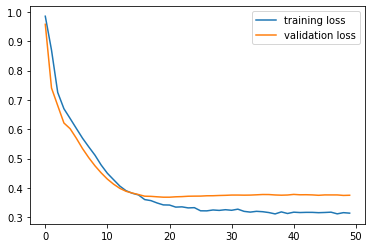

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 60s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 3s 658ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

Text(0.5, 1.0, 'train dataset')

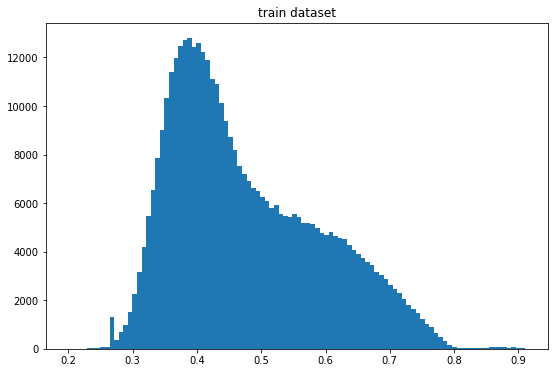

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
# plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.3848979322933542

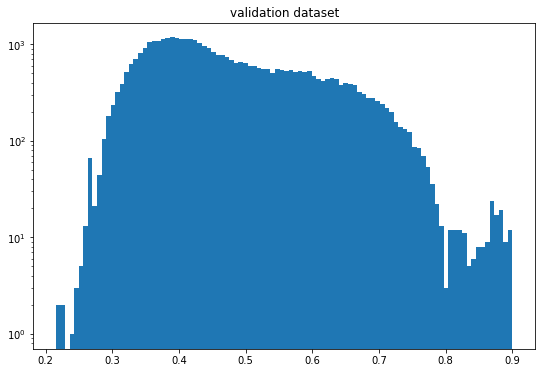

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.38658633915239204

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([173051, 178411, 175741, ..., 308814, 230259, 299203])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  173051
MAE:  0.9104247221055508
n_bunches       1227
bunch_index     1058
bunch_number     329
Name: 10722751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h59m14s.h5


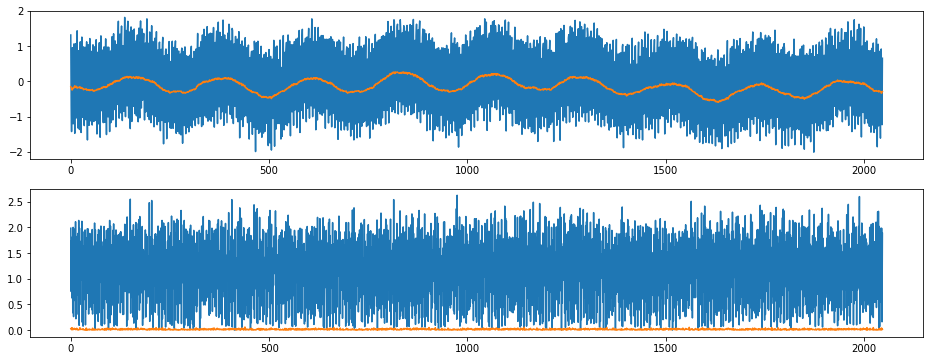

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  173051
MAE:  0.9104247221055508
n_bunches       1227
bunch_index     1058
bunch_number     329
Name: 10722751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h59m14s.h5


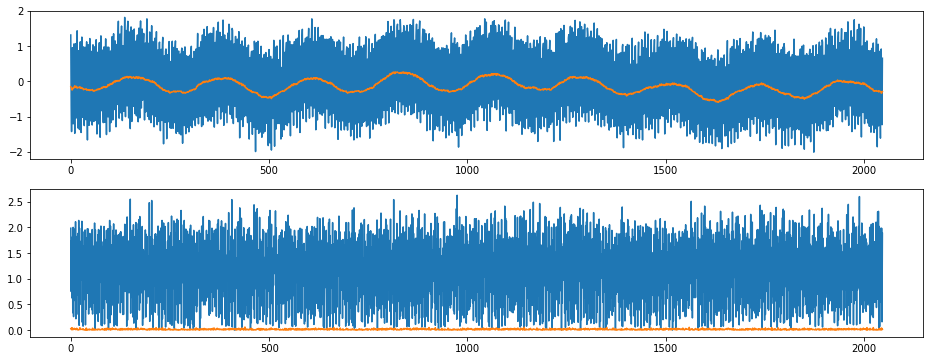

index:  178411
MAE:  0.9094826799764881
n_bunches       1868
bunch_index     3379
bunch_number    1827
Name: 4377425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_17h19m14s.h5


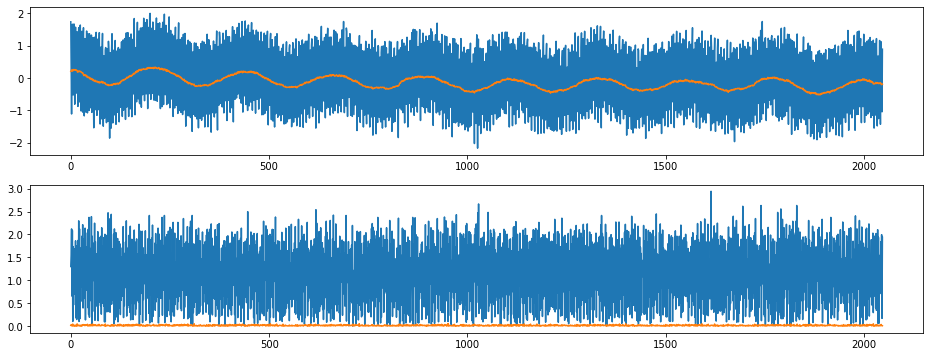

index:  175741
MAE:  0.9086526987438586
n_bunches       396
bunch_index     726
bunch_number    387
Name: 546405, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_12h30m20s.h5


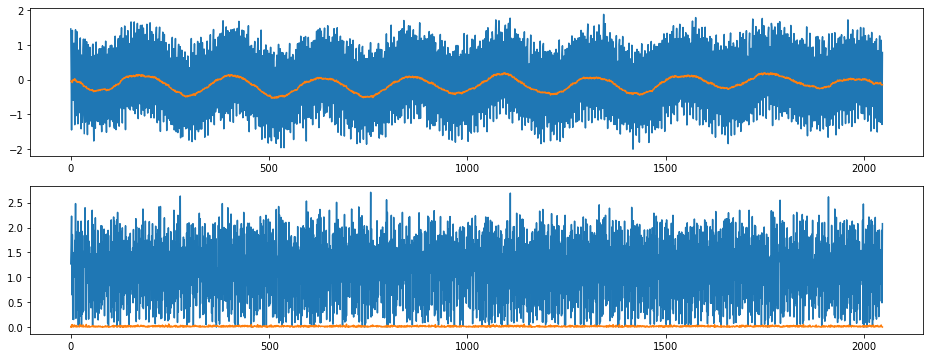

index:  173400
MAE:  0.9078872014371563
n_bunches       252
bunch_index     329
bunch_number    228
Name: 6882598, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7240/instability_data/07240_Inst_B1H_Q7_20180930_20h41m19s.h5


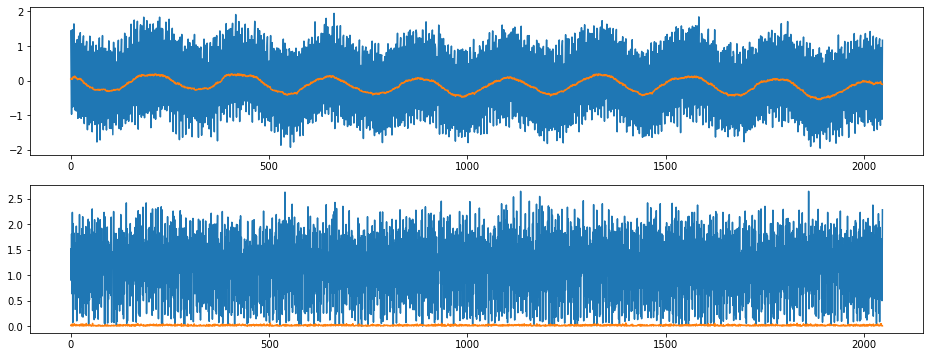

index:  158707
MAE:  0.9064374001353541
n_bunches       428
bunch_index     736
bunch_number    403
Name: 8418909, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_16h03m33s.h5


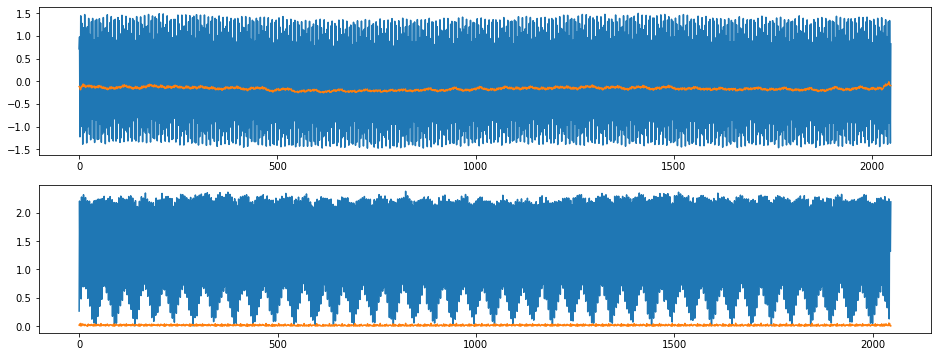

index:  159951
MAE:  0.9059996389226967
n_bunches       1868
bunch_index      262
bunch_number     136
Name: 4838998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_18h31m14s.h5


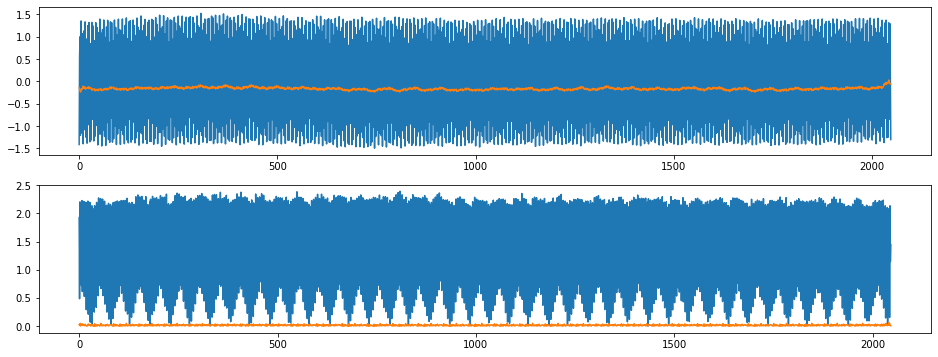

index:  409011
MAE:  0.905802098701527
n_bunches       228
bunch_index     678
bunch_number     59
Name: 3891820, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h56m14s.h5


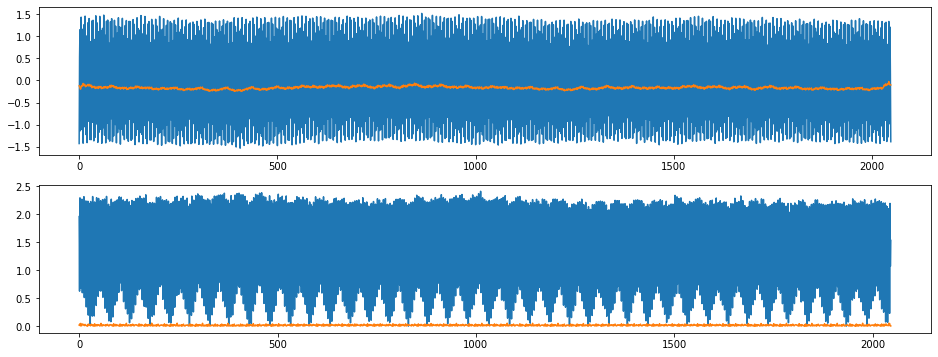

index:  175088
MAE:  0.9055741827256515
n_bunches        733
bunch_index     2663
bunch_number     563
Name: 1133209, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7482/instability_data/07482_Inst_B1H_Q7_20181128_22h52m44s.h5


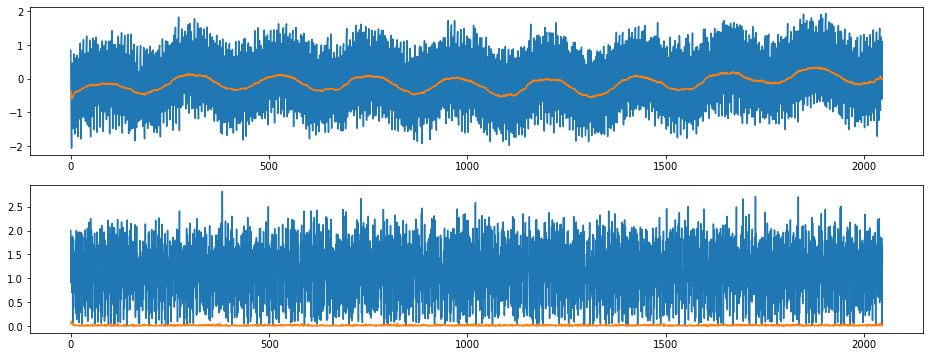

index:  157339
MAE:  0.9055674389945991
n_bunches        637
bunch_index     1087
bunch_number     612
Name: 11341893, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6630/instability_data/06630_Inst_B1H_Q7_20180502_01h06m31s.h5


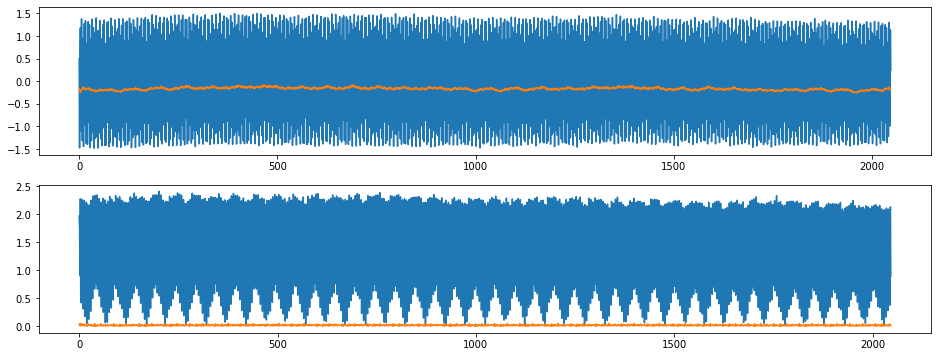

index:  177016
MAE:  0.9054653640286943
n_bunches       924
bunch_index     960
bunch_number    677
Name: 4472332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6672/instability_data/06672_Inst_B1H_Q7_20180511_17h48m15s.h5


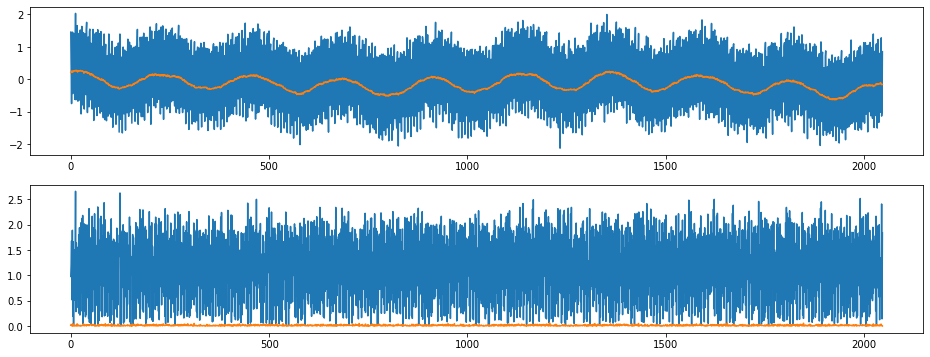

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  299203
MAE:  0.2002533845215013
n_bunches       540
bunch_index     385
bunch_number    271
Name: 9269805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6875/instability_data/06875_Inst_B1H_Q7_20180702_04h26m14s.h5


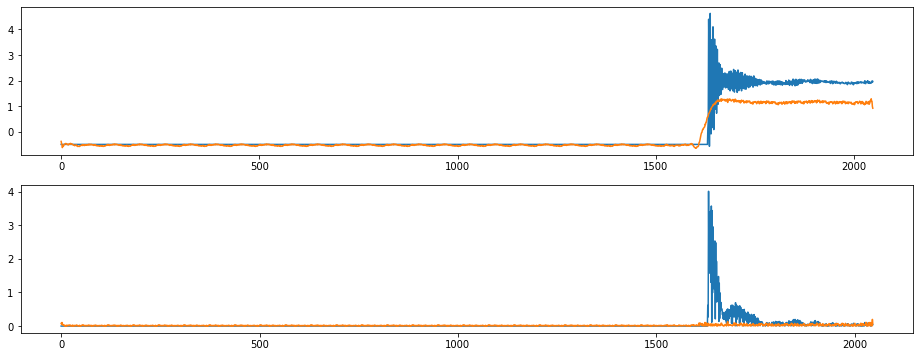

index:  230259
MAE:  0.21093499915815536
n_bunches       1836
bunch_index     2457
bunch_number    1309
Name: 2475637, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_13h21m13s.h5


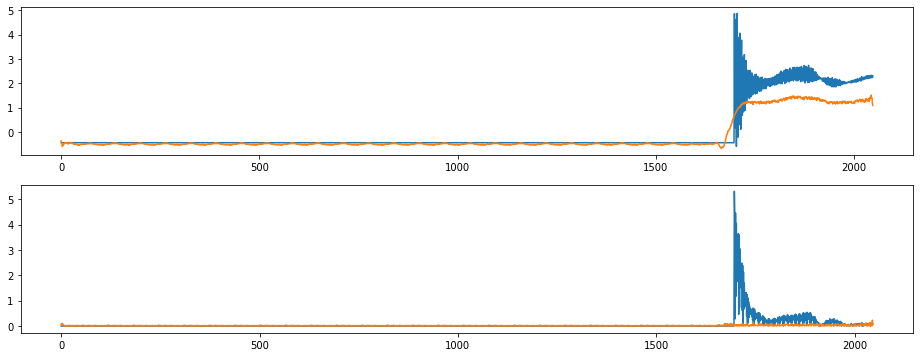

index:  308814
MAE:  0.21094552622152768
n_bunches       1292
bunch_index     1464
bunch_number     549
Name: 8397171, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h11m14s.h5


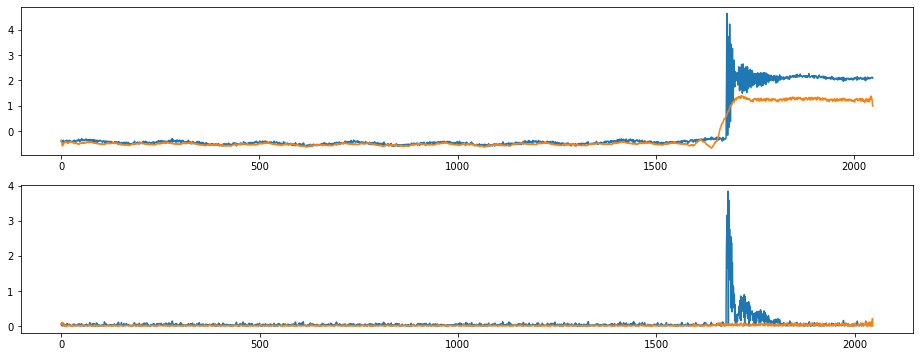

index:  252726
MAE:  0.2125528371455004
n_bunches        670
bunch_index     1942
bunch_number     410
Name: 8935190, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_20h56m15s.h5


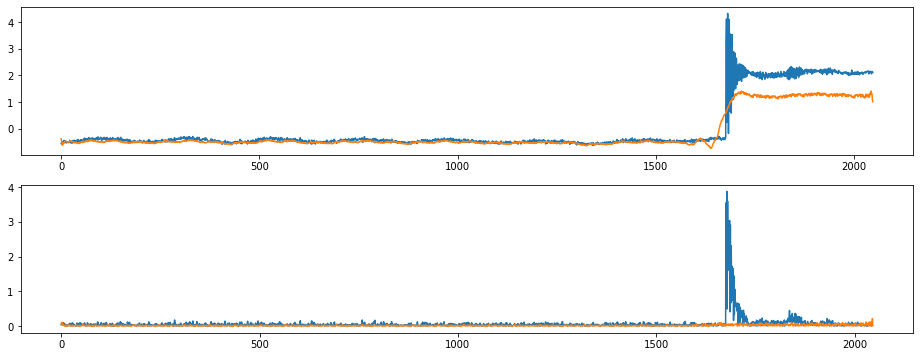

index:  149793
MAE:  0.21345012329258312
n_bunches       1868
bunch_index     3030
bunch_number    1620
Name: 9918388, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_03h27m14s.h5


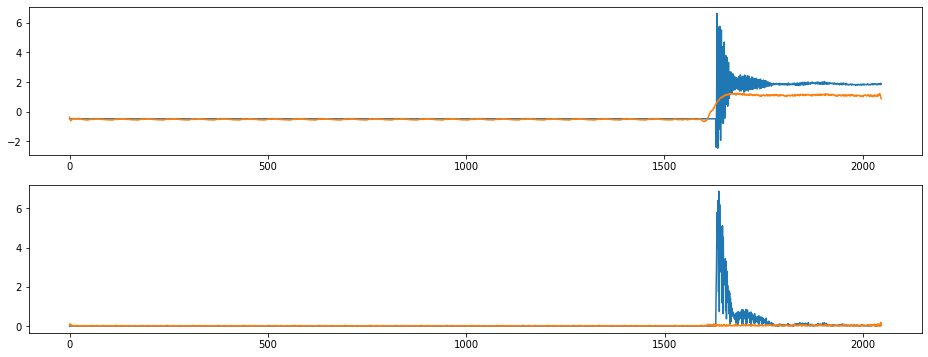

index:  112481
MAE:  0.21537840876795145
n_bunches        632
bunch_index     1235
bunch_number     228
Name: 8418090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_21h42m16s.h5


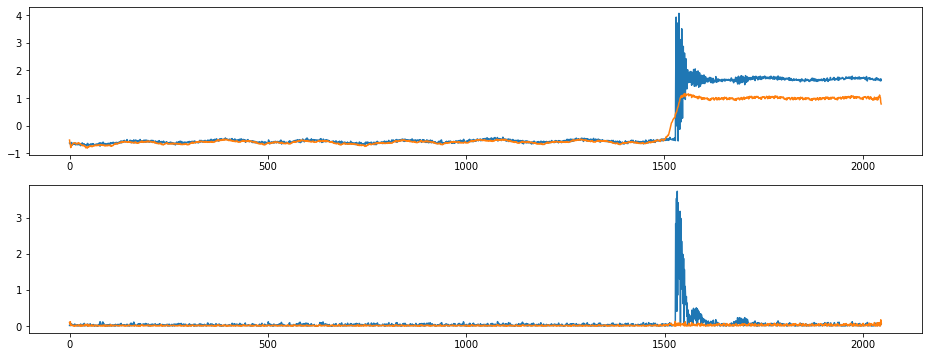

index:  260987
MAE:  0.21544554615011915
n_bunches       2556
bunch_index     3371
bunch_number    2520
Name: 4067670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h31m13s.h5


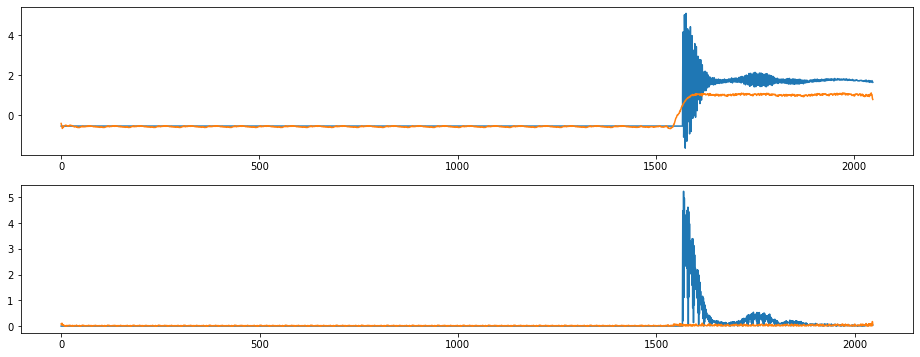

index:  318982
MAE:  0.21649941635560413
n_bunches       156
bunch_index     361
bunch_number    145
Name: 1656961, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6671/instability_data/06671_Inst_B1H_Q7_20180511_16h02m27s.h5


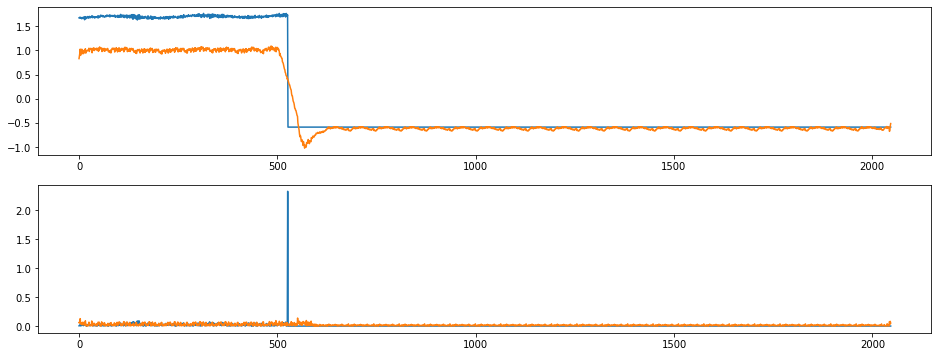

index:  385134
MAE:  0.2169628657836281
n_bunches       339
bunch_index     159
bunch_number     38
Name: 10913863, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_13h43m14s.h5


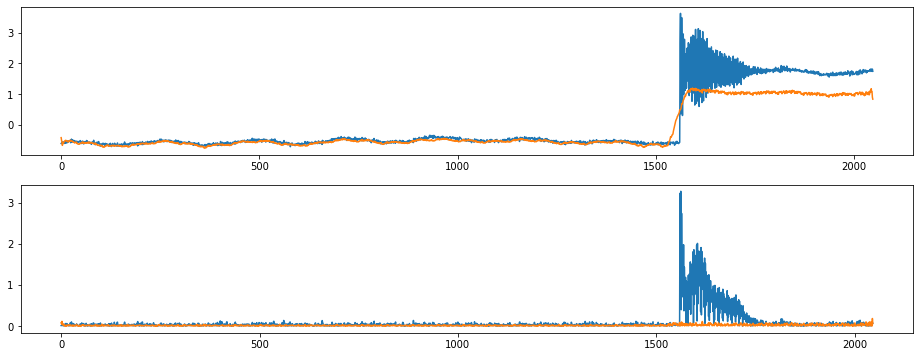

index:  346148
MAE:  0.21782686786929717
n_bunches       2556
bunch_index     2062
bunch_number    1505
Name: 3256896, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_14h41m14s.h5


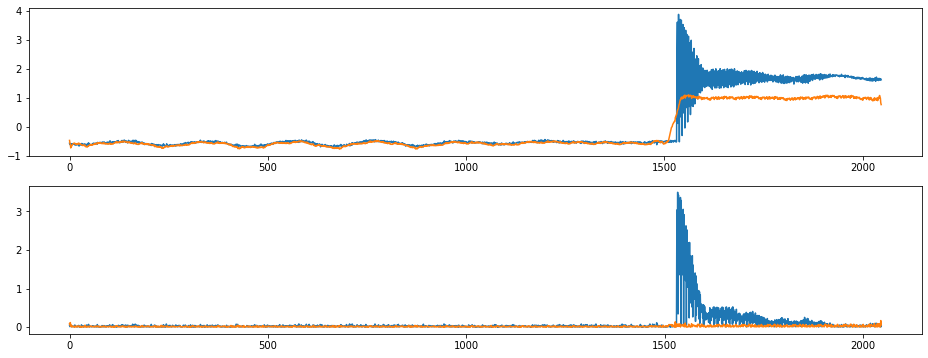

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  150112
MAE:  0.3848978700677149
n_bunches       1916
bunch_index     3113
bunch_number    1716
Name: 3387356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_17h49m15s.h5


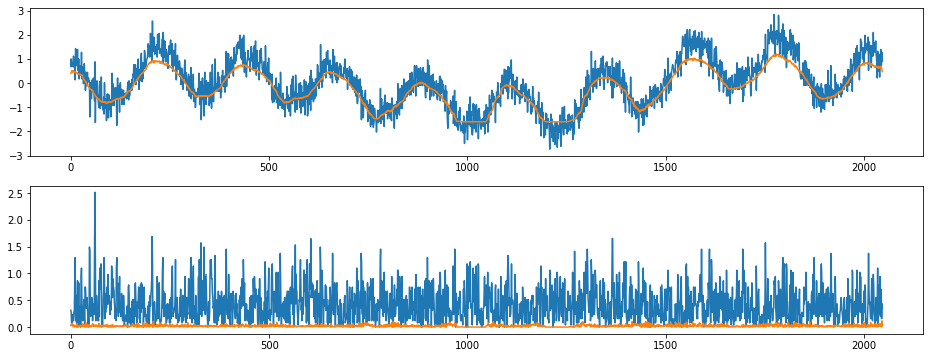

index:  372460
MAE:  0.38489851637414396
n_bunches       460
bunch_index     274
bunch_number    142
Name: 6740533, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6179/instability_data/06179_Inst_B1H_Q7_20170908_23h53m41s.h5


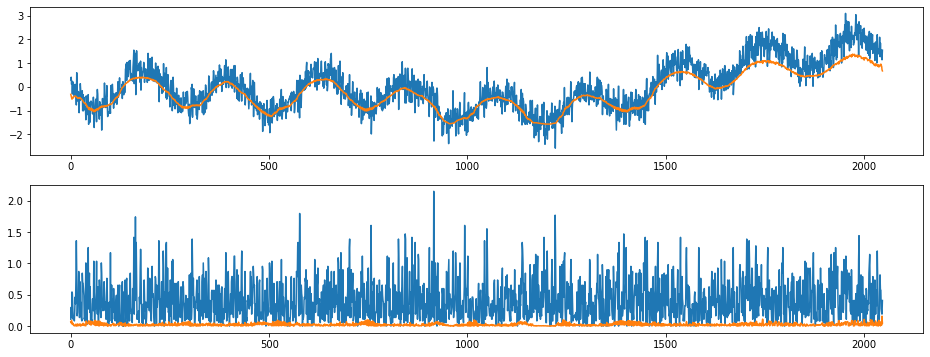

index:  148556
MAE:  0.3848986191901071
n_bunches       1916
bunch_index      758
bunch_number     404
Name: 10096314, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/instability_data/06245_Inst_B1H_Q7_20170926_14h43m25s.h5


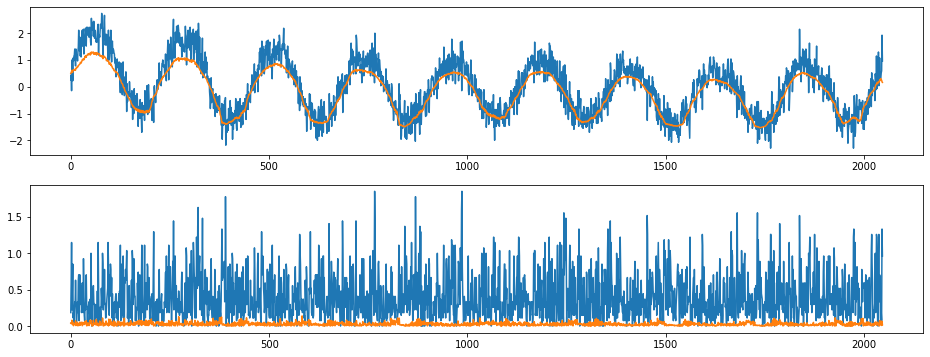

index:  35602
MAE:  0.3848970780035904
n_bunches       620
bunch_index     338
bunch_number    141
Name: 10350213, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6390/instability_data/06390_Inst_B1H_Q7_20171115_15h35m30s.h5


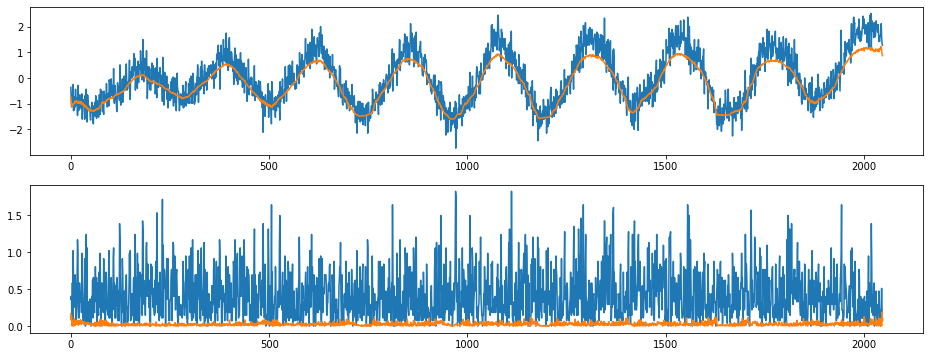

index:  50458
MAE:  0.3848969323183958
n_bunches       300
bunch_index     438
bunch_number    231
Name: 6853906, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_06h41m44s.h5


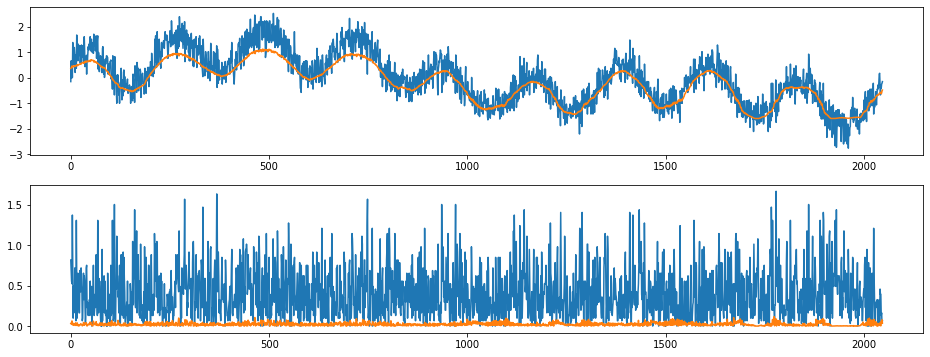

index:  21834
MAE:  0.3848968006099235
n_bunches       2556
bunch_index     2389
bunch_number    1768
Name: 10412635, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_16h11m14s.h5


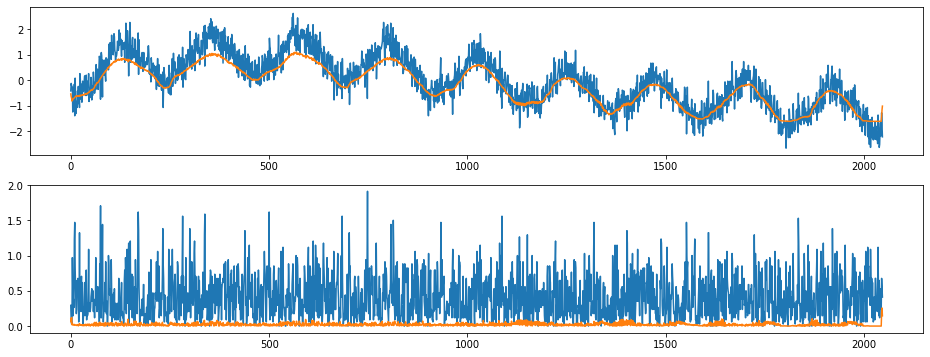

index:  297832
MAE:  0.38489658437208457
n_bunches       1868
bunch_index     2955
bunch_number    1588
Name: 11640613, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_11h57m14s.h5


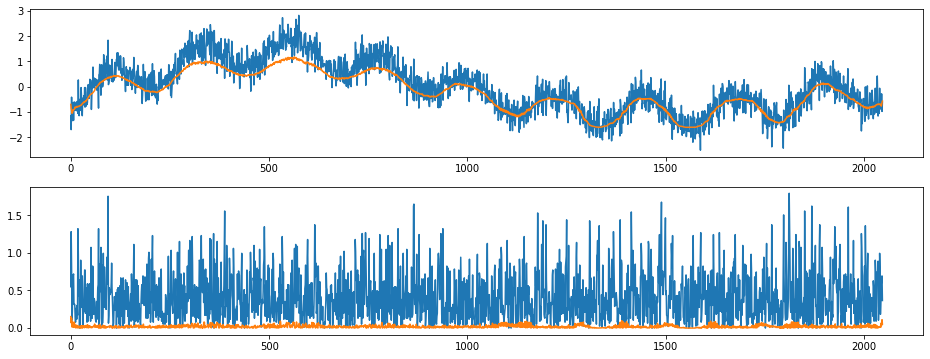

index:  200419
MAE:  0.38489640518693335
n_bunches       1868
bunch_index      940
bunch_number     501
Name: 2327794, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/instability_data/06275_Inst_B1H_Q7_20171006_09h02m10s.h5


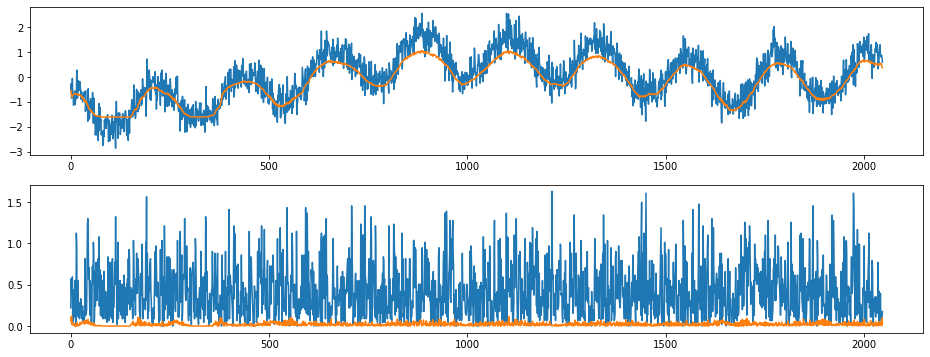

index:  128401
MAE:  0.3848996685507624
n_bunches       924
bunch_index     135
bunch_number     79
Name: 2536996, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6960/instability_data/06960_Inst_B1H_Q7_20180722_08h05m25s.h5


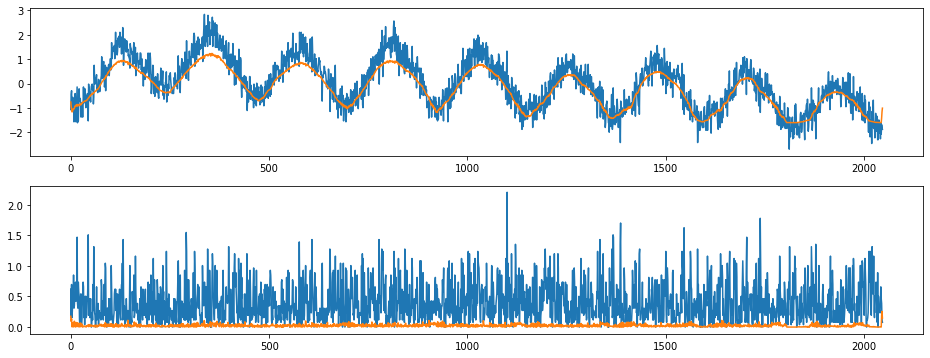

index:  79042
MAE:  0.3848960209326994
n_bunches       1916
bunch_index     1341
bunch_number     736
Name: 10453319, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_07h00m15s.h5


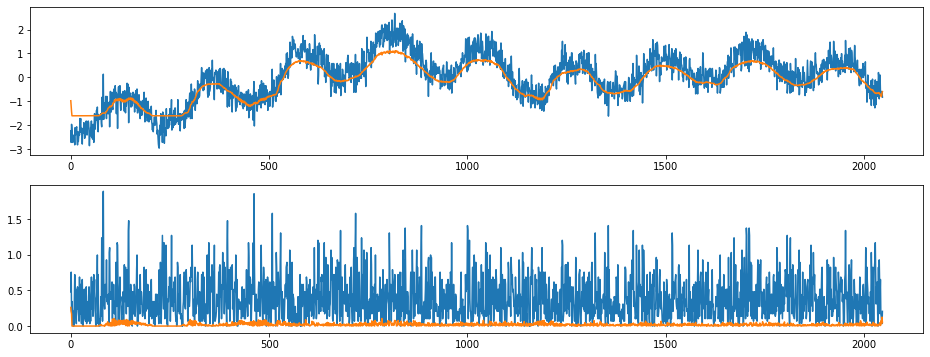

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  215994
MAE:  0.6000000793275322
n_bunches       1868
bunch_index      592
bunch_number     312
Name: 10560434, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_16h29m15s.h5


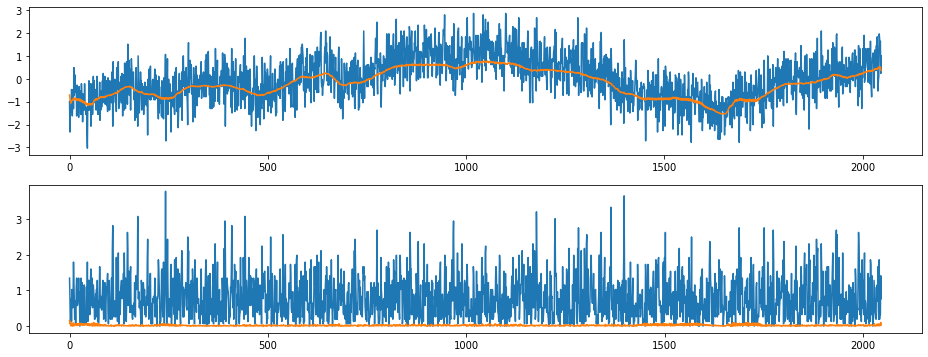

index:  257135
MAE:  0.5999986953389158
n_bunches        303
bunch_index     1801
bunch_number     179
Name: 755838, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_08h39m44s.h5


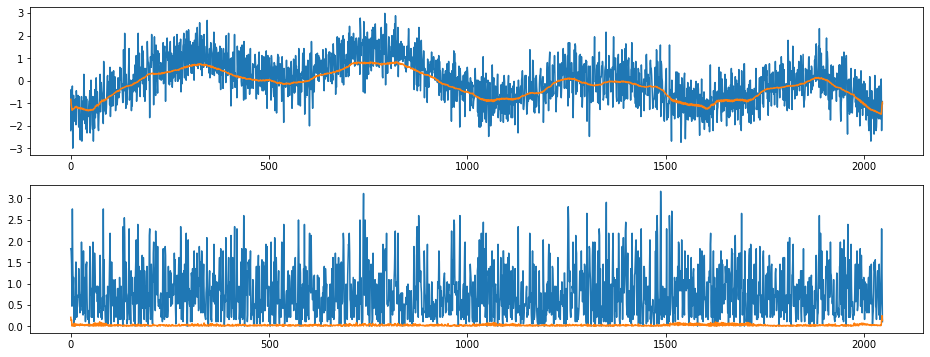

index:  135795
MAE:  0.600003232934519
n_bunches       908
bunch_index     238
bunch_number    120
Name: 8891929, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6415/instability_data/06415_Inst_B1H_Q7_20171125_04h19m38s.h5


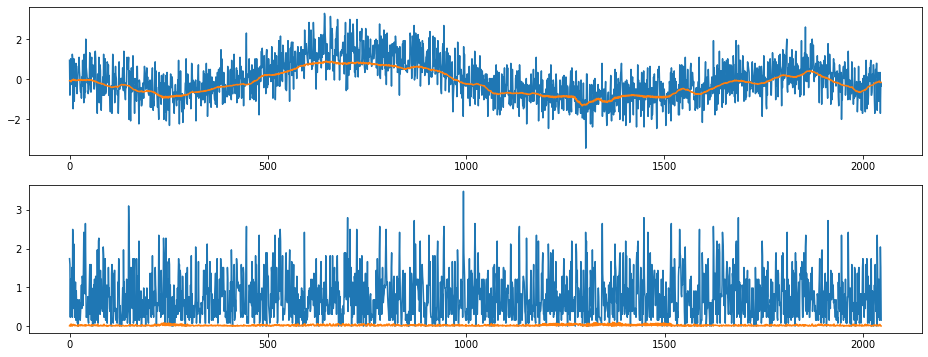

index:  21566
MAE:  0.5999960517943685
n_bunches       502
bunch_index      91
bunch_number     15
Name: 13929, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/instability_data/07486_Inst_B1H_Q7_20181130_08h31m15s.h5


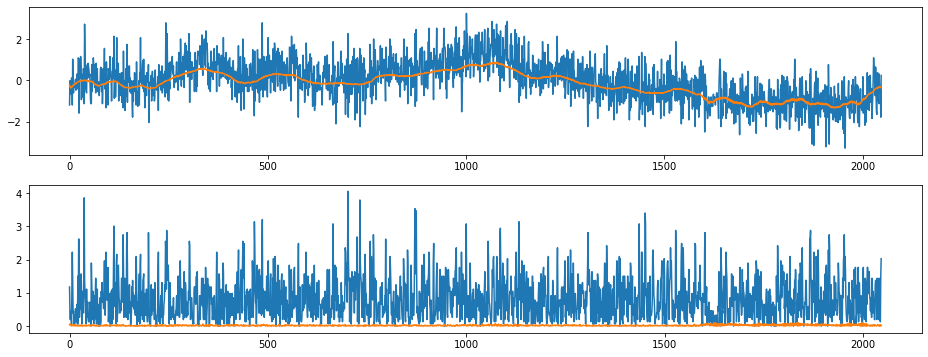

index:  269047
MAE:  0.5999952630378256
n_bunches       780
bunch_index     970
bunch_number    699
Name: 10764994, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7274/instability_data/07274_Inst_B1H_Q7_20181011_00h27m24s.h5


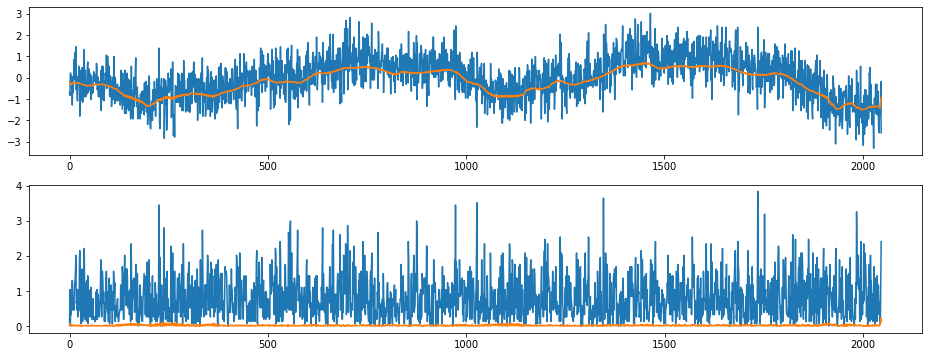

index:  346651
MAE:  0.5999949685050054
n_bunches       1020
bunch_index      299
bunch_number     195
Name: 9378097, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6457/instability_data/06457_Inst_B1H_Q7_20171203_18h53m15s.h5


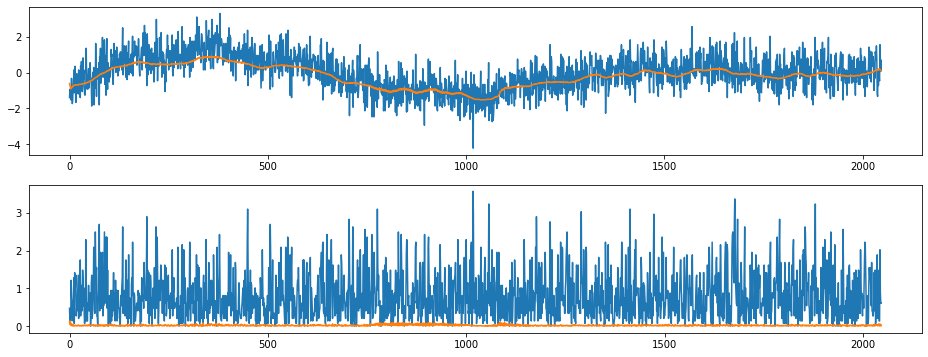

index:  362738
MAE:  0.5999944156330892
n_bunches       636
bunch_index     540
bunch_number    375
Name: 7059210, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6765/instability_data/06765_Inst_B1H_Q7_20180607_13h48m15s.h5


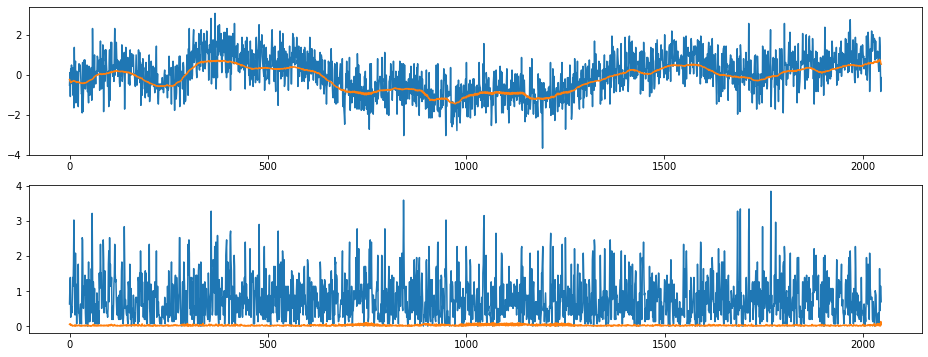

index:  36730
MAE:  0.5999936341535754
n_bunches         10
bunch_index     2100
bunch_number       6
Name: 6466023, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6699/instability_data/06699_Inst_B1H_Q7_20180518_23h25m14s.h5


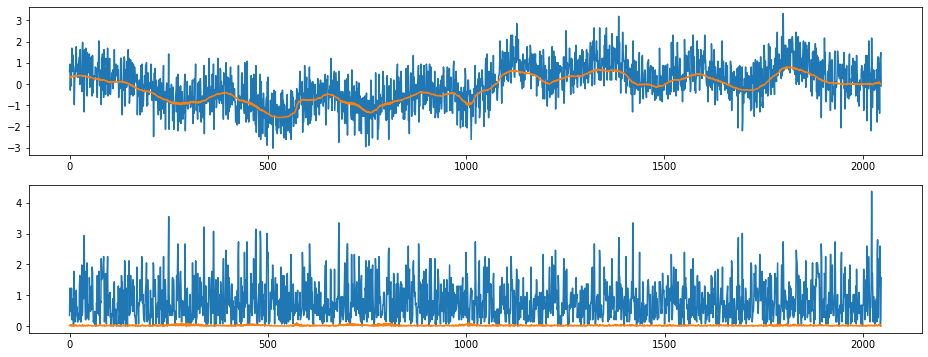

index:  196860
MAE:  0.599993633834587
n_bunches       1916
bunch_index     3101
bunch_number    1708
Name: 11495669, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170930_00h50m15s.h5


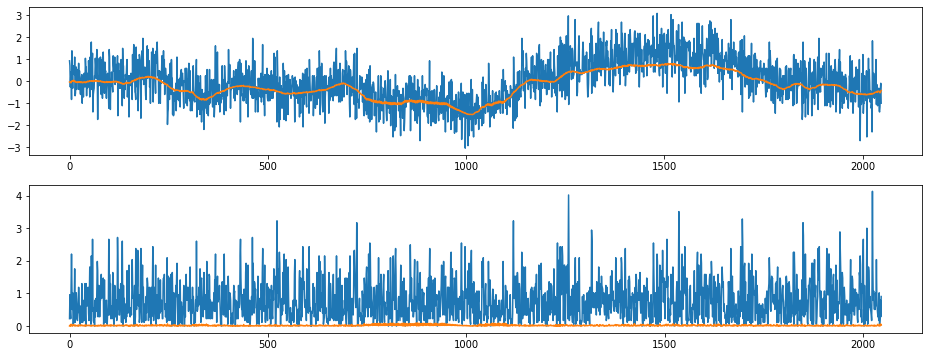

index:  409426
MAE:  0.6000077563518049
n_bunches       2556
bunch_index     2259
bunch_number    1676
Name: 10389951, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7080/instability_data/07080_Inst_B1H_Q7_20180823_23h24m14s.h5


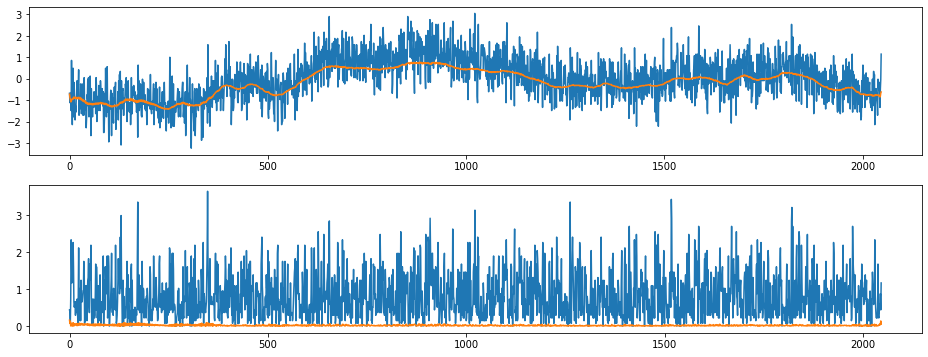

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

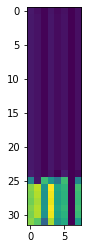

In [36]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  299203
MAE:  0.2002533845215013
n_bunches       540
bunch_index     385
bunch_number    271
Name: 9269805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6875/instability_data/06875_Inst_B1H_Q7_20180702_04h26m14s.h5


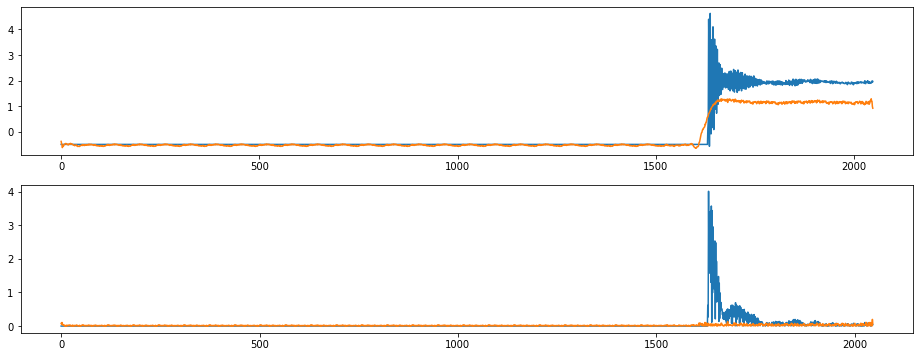

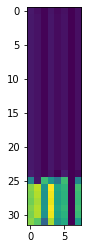

index:  230259
MAE:  0.21093499915815536
n_bunches       1836
bunch_index     2457
bunch_number    1309
Name: 2475637, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_13h21m13s.h5


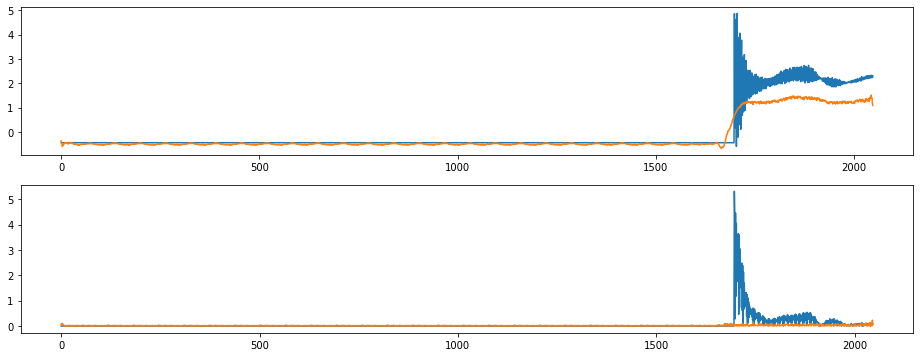

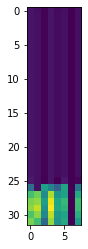

index:  308814
MAE:  0.21094552622152768
n_bunches       1292
bunch_index     1464
bunch_number     549
Name: 8397171, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h11m14s.h5


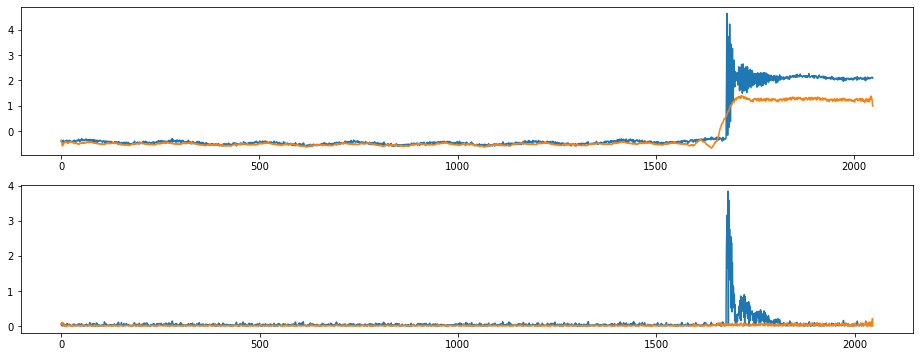

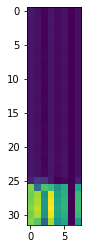

index:  252726
MAE:  0.2125528371455004
n_bunches        670
bunch_index     1942
bunch_number     410
Name: 8935190, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_20h56m15s.h5


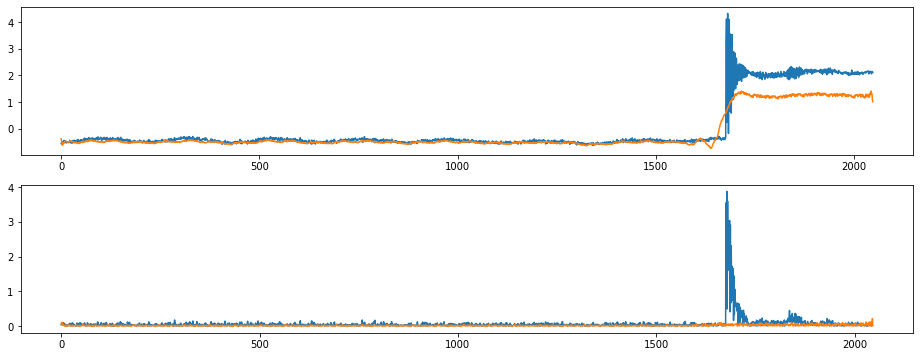

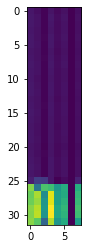

index:  149793
MAE:  0.21345012329258312
n_bunches       1868
bunch_index     3030
bunch_number    1620
Name: 9918388, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_03h27m14s.h5


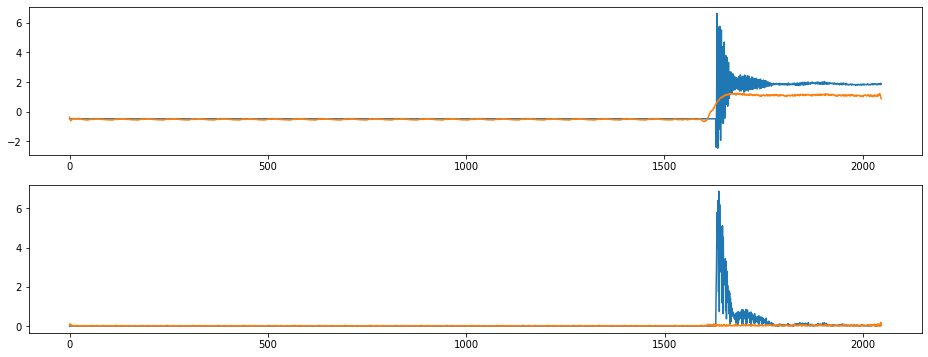

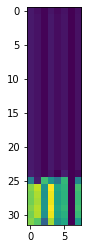

index:  112481
MAE:  0.21537840876795145
n_bunches        632
bunch_index     1235
bunch_number     228
Name: 8418090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_21h42m16s.h5


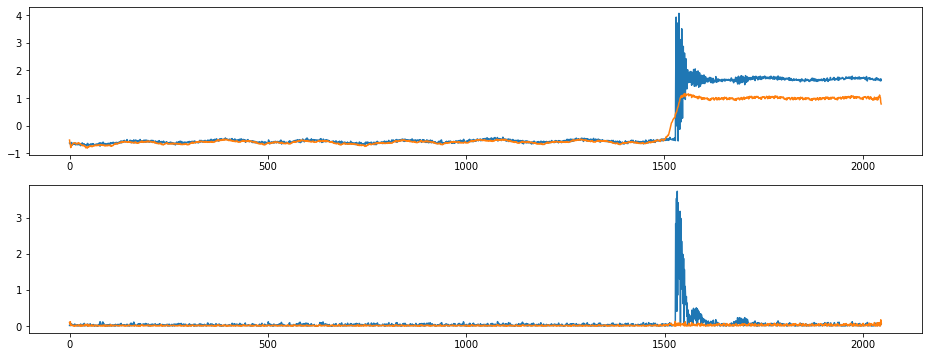

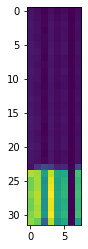

index:  260987
MAE:  0.21544554615011915
n_bunches       2556
bunch_index     3371
bunch_number    2520
Name: 4067670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h31m13s.h5


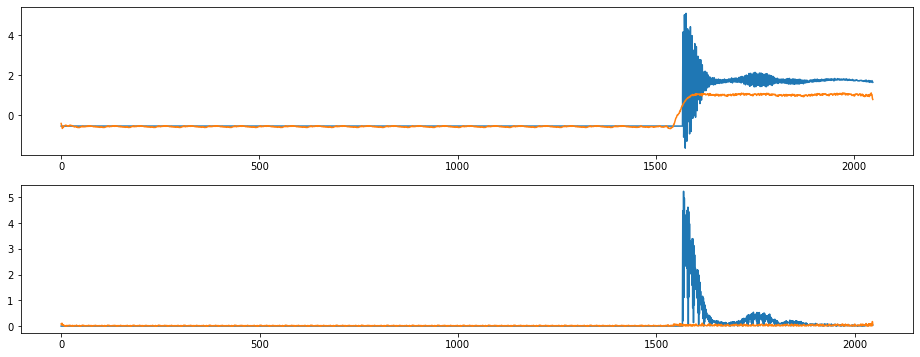

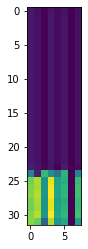

index:  318982
MAE:  0.21649941635560413
n_bunches       156
bunch_index     361
bunch_number    145
Name: 1656961, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6671/instability_data/06671_Inst_B1H_Q7_20180511_16h02m27s.h5


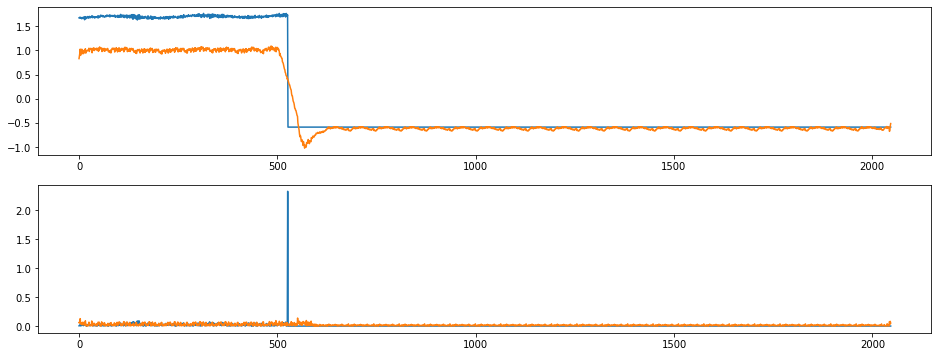

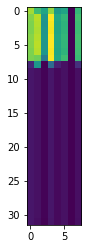

index:  385134
MAE:  0.2169628657836281
n_bunches       339
bunch_index     159
bunch_number     38
Name: 10913863, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6594/instability_data/06594_Inst_B1H_Q7_20180422_13h43m14s.h5


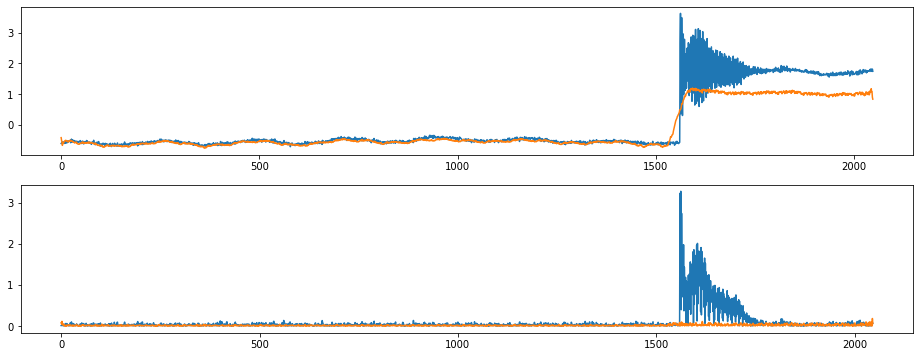

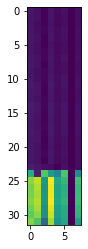

index:  346148
MAE:  0.21782686786929717
n_bunches       2556
bunch_index     2062
bunch_number    1505
Name: 3256896, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_14h41m14s.h5


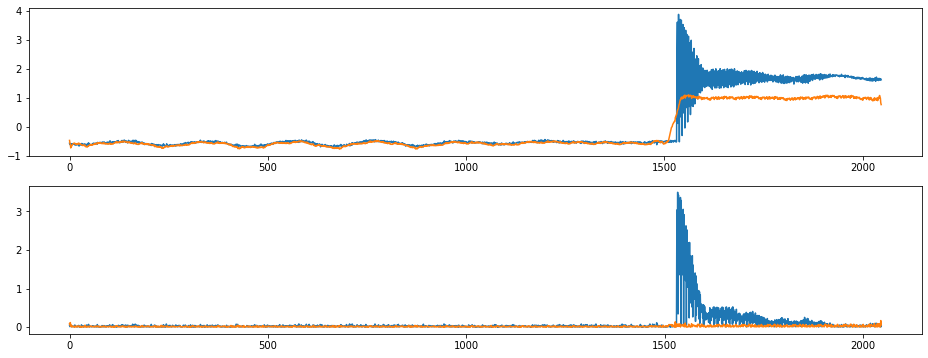

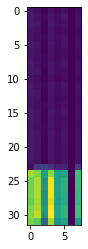

In [37]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  173051
MAE:  0.9104247221055508
n_bunches       1227
bunch_index     1058
bunch_number     329
Name: 10722751, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h59m14s.h5


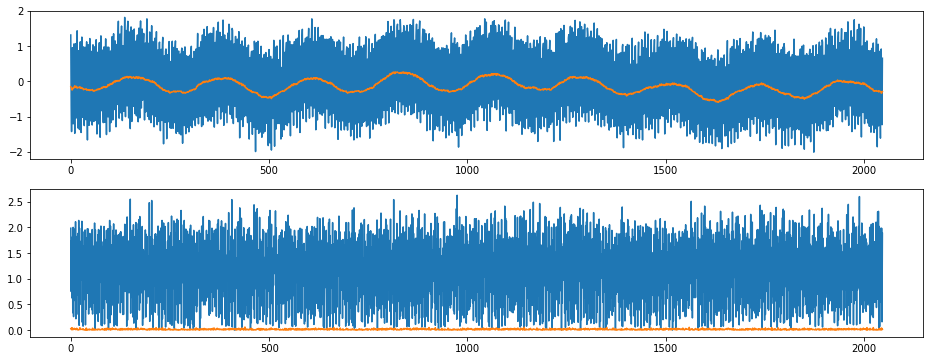

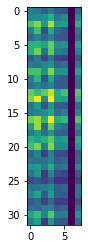

index:  178411
MAE:  0.9094826799764881
n_bunches       1868
bunch_index     3379
bunch_number    1827
Name: 4377425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_17h19m14s.h5


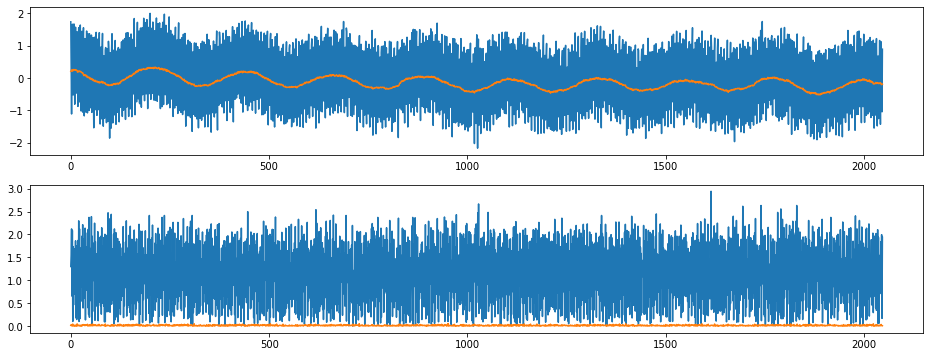

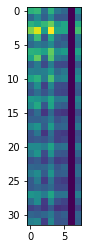

index:  175741
MAE:  0.9086526987438586
n_bunches       396
bunch_index     726
bunch_number    387
Name: 546405, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_12h30m20s.h5


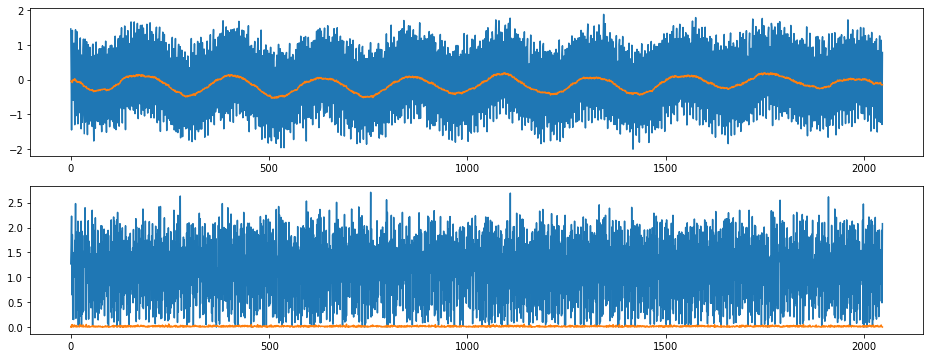

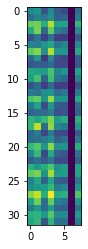

index:  173400
MAE:  0.9078872014371563
n_bunches       252
bunch_index     329
bunch_number    228
Name: 6882598, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7240/instability_data/07240_Inst_B1H_Q7_20180930_20h41m19s.h5


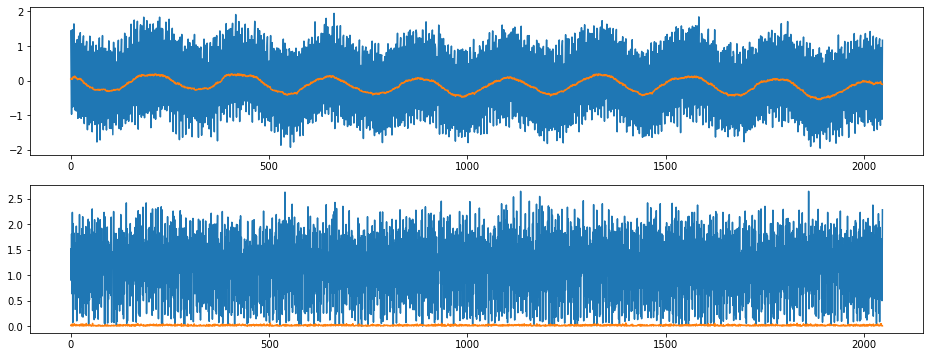

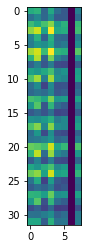

index:  158707
MAE:  0.9064374001353541
n_bunches       428
bunch_index     736
bunch_number    403
Name: 8418909, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_16h03m33s.h5


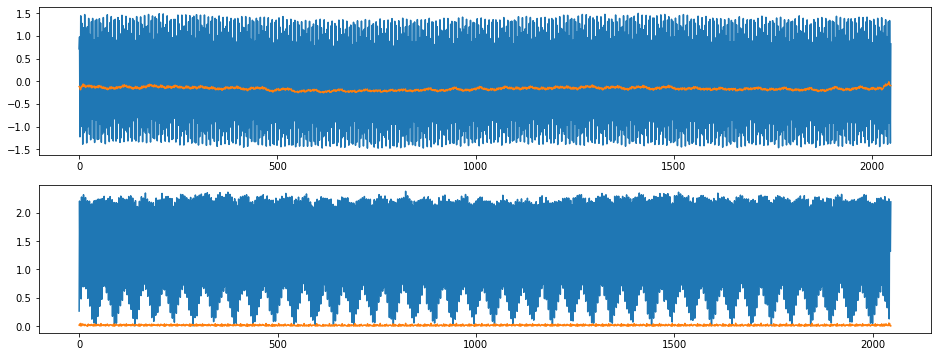

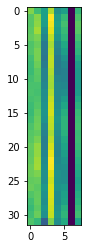

index:  159951
MAE:  0.9059996389226967
n_bunches       1868
bunch_index      262
bunch_number     136
Name: 4838998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_18h31m14s.h5


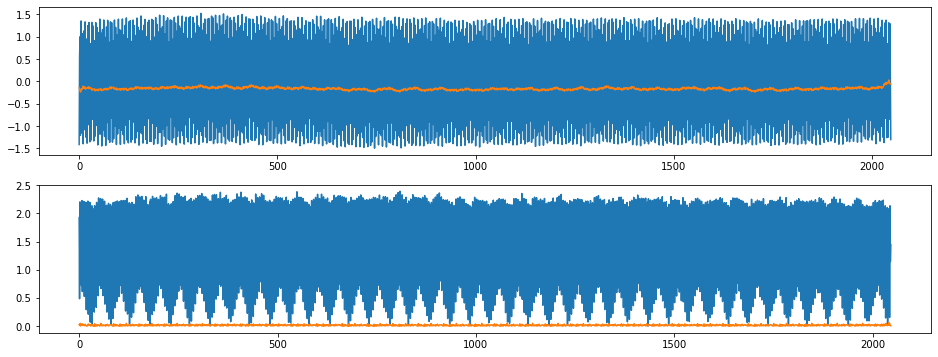

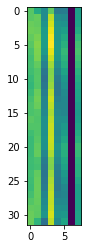

index:  409011
MAE:  0.905802098701527
n_bunches       228
bunch_index     678
bunch_number     59
Name: 3891820, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h56m14s.h5


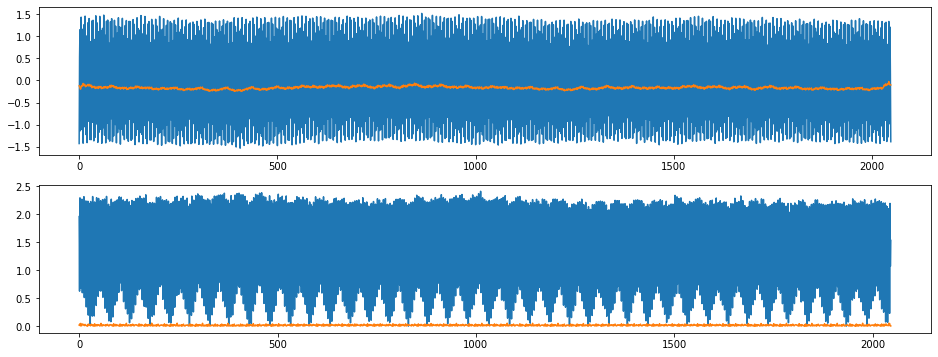

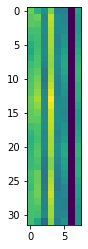

index:  175088
MAE:  0.9055741827256515
n_bunches        733
bunch_index     2663
bunch_number     563
Name: 1133209, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7482/instability_data/07482_Inst_B1H_Q7_20181128_22h52m44s.h5


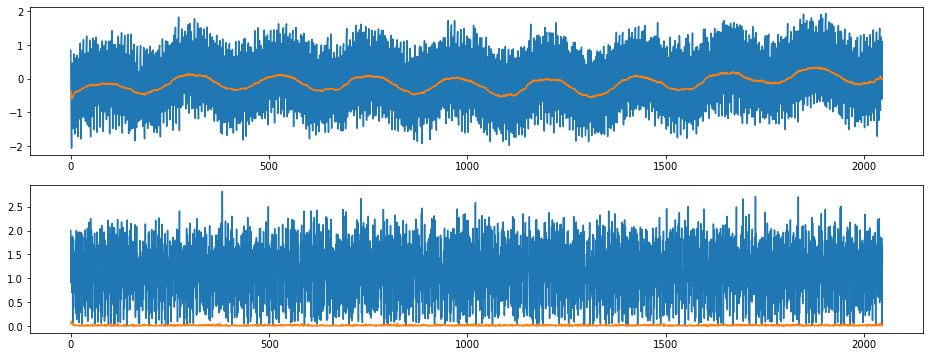

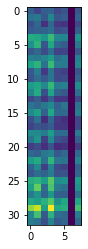

index:  157339
MAE:  0.9055674389945991
n_bunches        637
bunch_index     1087
bunch_number     612
Name: 11341893, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6630/instability_data/06630_Inst_B1H_Q7_20180502_01h06m31s.h5


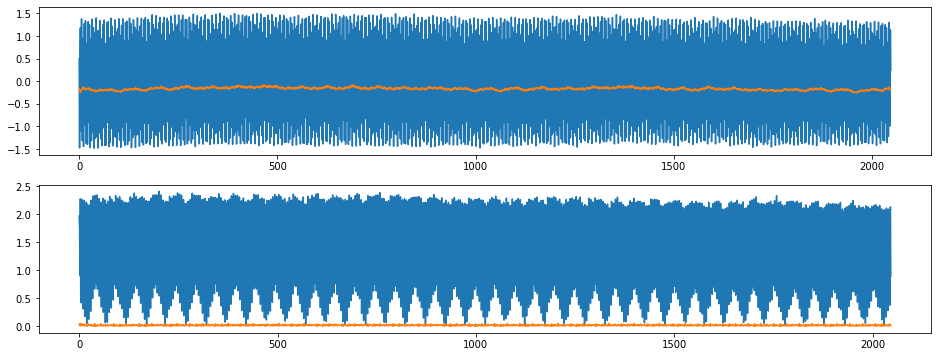

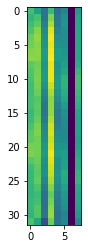

index:  177016
MAE:  0.9054653640286943
n_bunches       924
bunch_index     960
bunch_number    677
Name: 4472332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6672/instability_data/06672_Inst_B1H_Q7_20180511_17h48m15s.h5


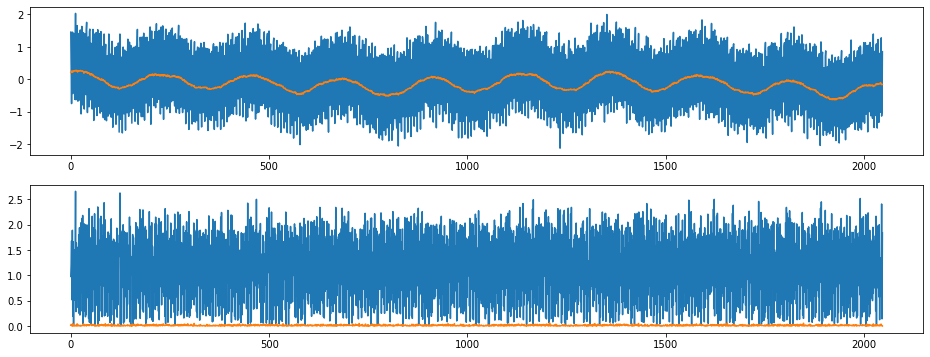

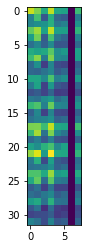

index:  179517
MAE:  0.905397723849718
n_bunches        987
bunch_index     1362
bunch_number     387
Name: 1245470, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_21h08m14s.h5


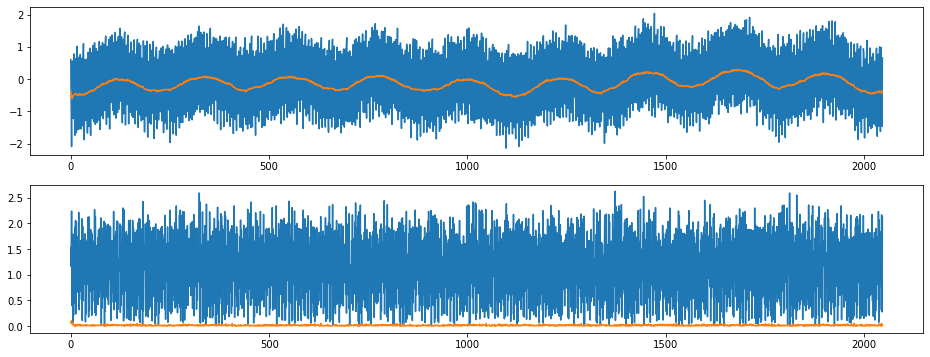

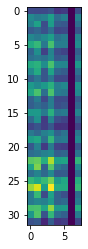

index:  173314
MAE:  0.9053307513118524
n_bunches       1868
bunch_index     1755
bunch_number     932
Name: 5144985, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171107_06h38m14s.h5


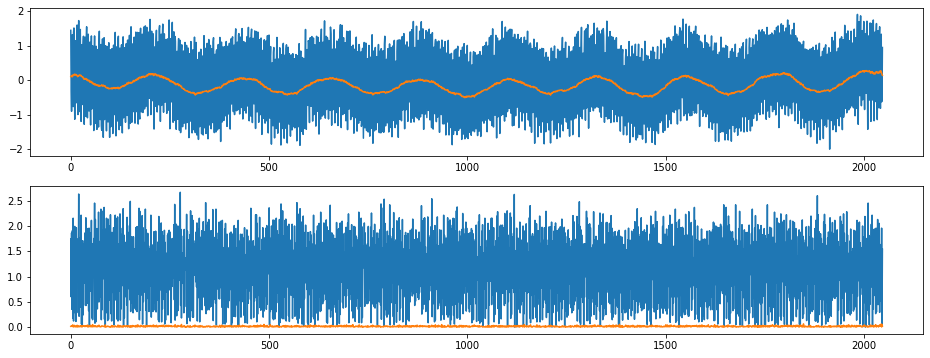

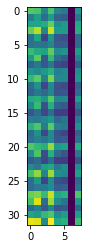

index:  402259
MAE:  0.9050986712913054
n_bunches       1868
bunch_index     1018
bunch_number     536
Name: 9120449, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171107_03h40m14s.h5


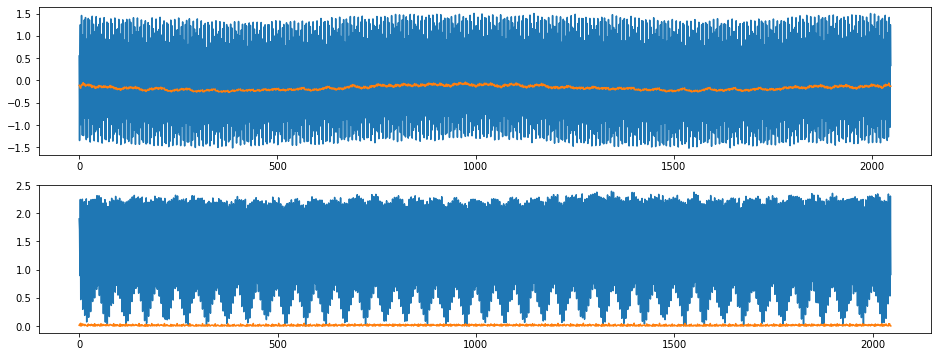

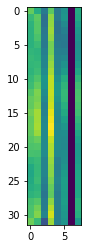

index:  176184
MAE:  0.904928834084084
n_bunches       286
bunch_index     314
bunch_number     28
Name: 1443305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/instability_data/06984_Inst_B1H_Q7_20180727_01h04m14s.h5


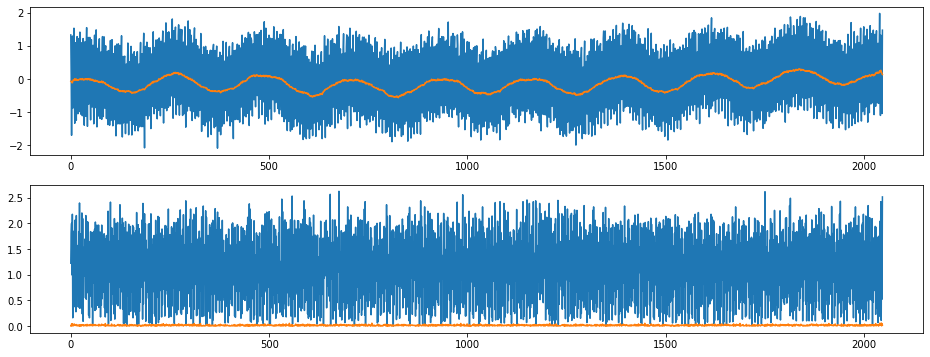

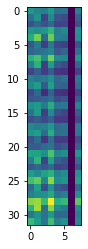

index:  155859
MAE:  0.9049078310722269
n_bunches        987
bunch_index     1392
bunch_number     458
Name: 3690819, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_06h52m14s.h5


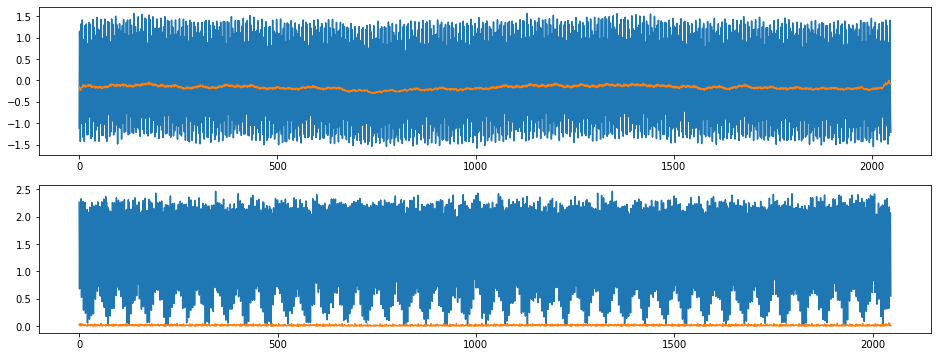

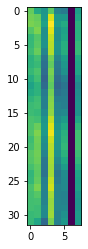

index:  158566
MAE:  0.9048654089999147
n_bunches       1868
bunch_index     2962
bunch_number    1595
Name: 9318311, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_19h30m14s.h5


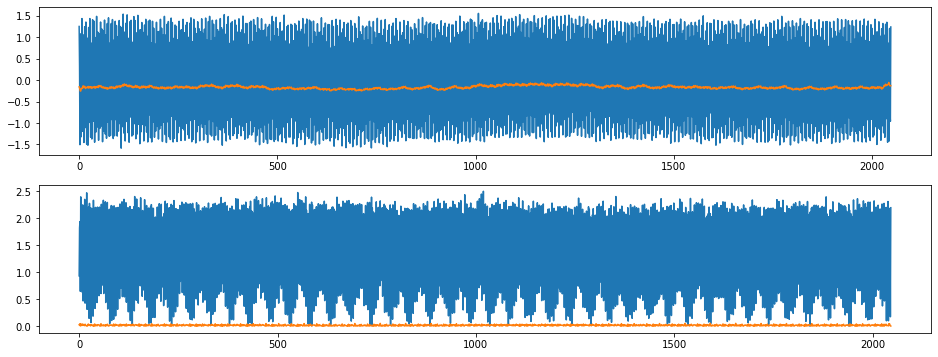

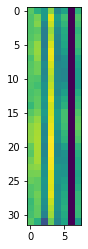

index:  405887
MAE:  0.9047600054877494
n_bunches       1916
bunch_index      486
bunch_number     264
Name: 1525074, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_07h20m15s.h5


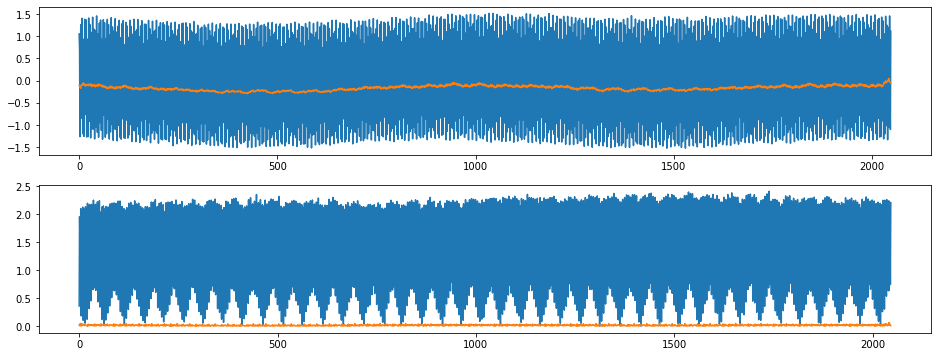

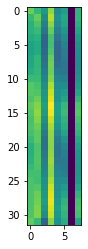

index:  314814
MAE:  0.9042848289111023
n_bunches       300
bunch_index     411
bunch_number    212
Name: 6292356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6278/instability_data/06278_Inst_B1H_Q7_20171006_22h56m01s.h5


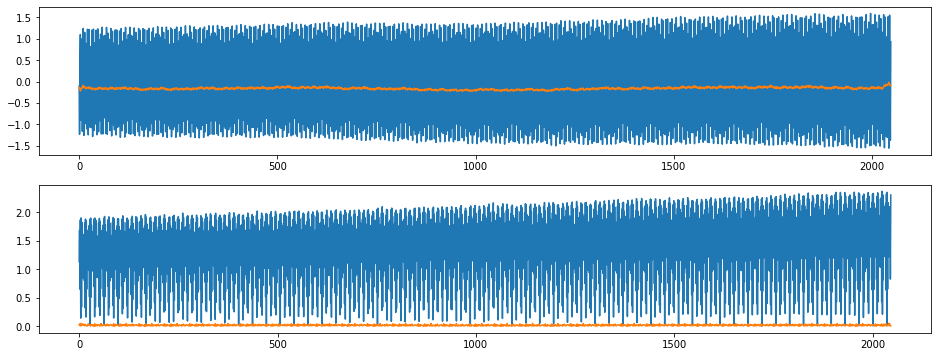

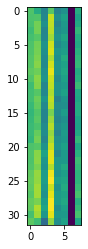

index:  158965
MAE:  0.9041438668242523
n_bunches        908
bunch_index     1481
bunch_number     810
Name: 4501527, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6185/instability_data/06185_Inst_B1H_Q7_20170910_02h55m26s.h5


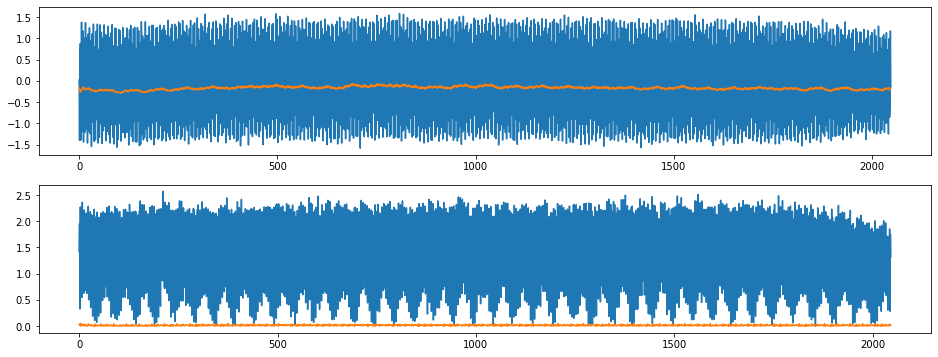

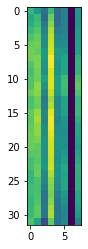

index:  313592
MAE:  0.9041364532961447
n_bunches       1868
bunch_index     1922
bunch_number    1022
Name: 9614885, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_02h52m14s.h5


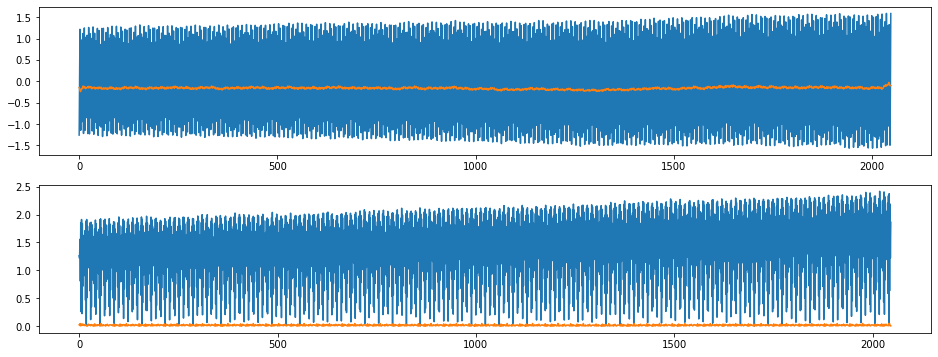

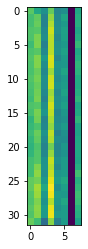

index:  312466
MAE:  0.9041073773162656
n_bunches       396
bunch_index     265
bunch_number    171
Name: 10691867, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7024/instability_data/07024_Inst_B1H_Q7_20180805_07h39m40s.h5


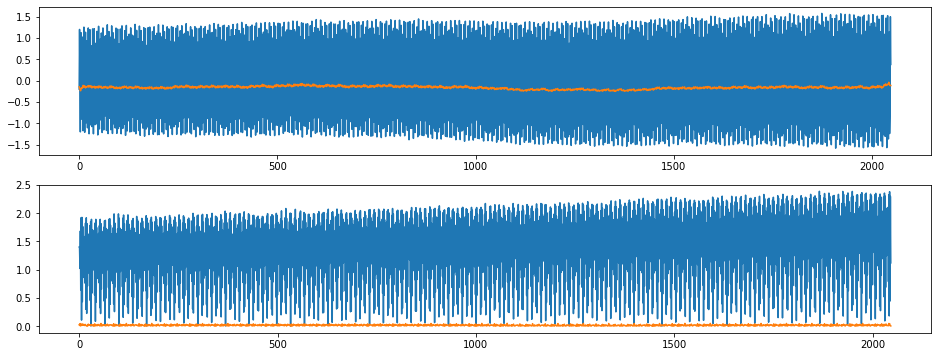

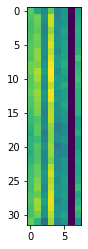

index:  172725
MAE:  0.9038643674779985
n_bunches       1068
bunch_index      307
bunch_number     206
Name: 10544981, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7127/instability_data/07127_Inst_B1H_Q7_20180905_12h57m00s.h5


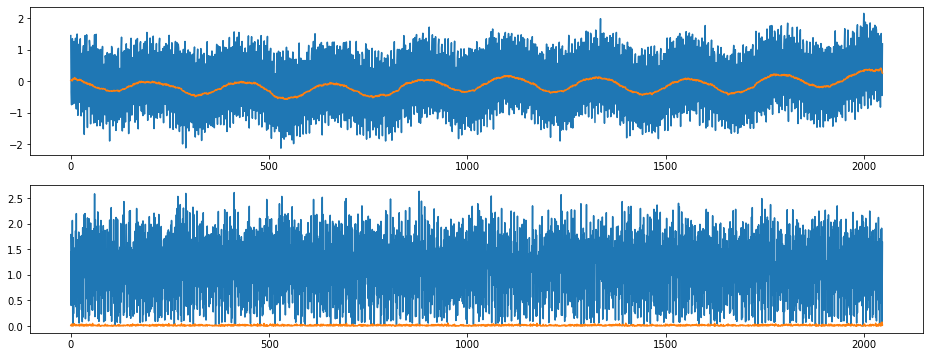

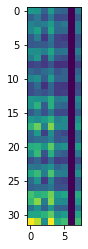

index:  403640
MAE:  0.9037389298685568
n_bunches       1227
bunch_index      300
bunch_number     162
Name: 9362443, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_05h06m15s.h5


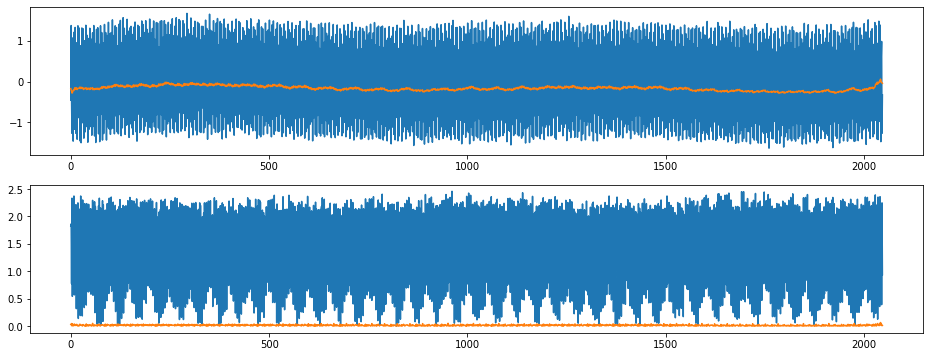

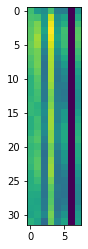

index:  172591
MAE:  0.9037141048827324
n_bunches       524
bunch_index     932
bunch_number    497
Name: 7223322, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6415/instability_data/06415_Inst_B1H_Q7_20171125_04h15m55s.h5


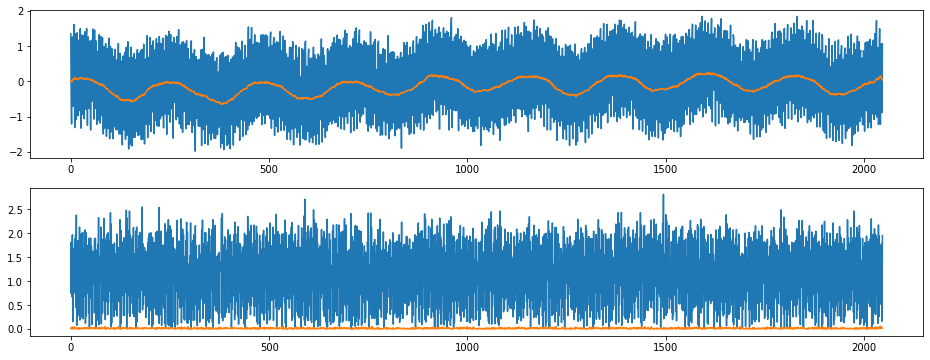

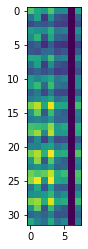

index:  315572
MAE:  0.9036043142554941
n_bunches        924
bunch_index     1043
bunch_number     765
Name: 4227729, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7112/instability_data/07112_Inst_B1H_Q7_20180901_12h08m54s.h5


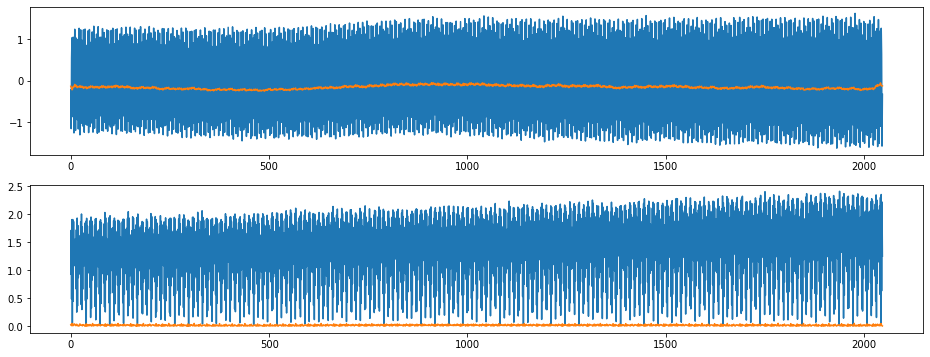

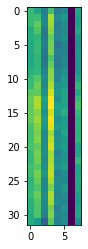

index:  408908
MAE:  0.9034185217629735
n_bunches       2556
bunch_index     1738
bunch_number    1283
Name: 11075670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_13h51m14s.h5


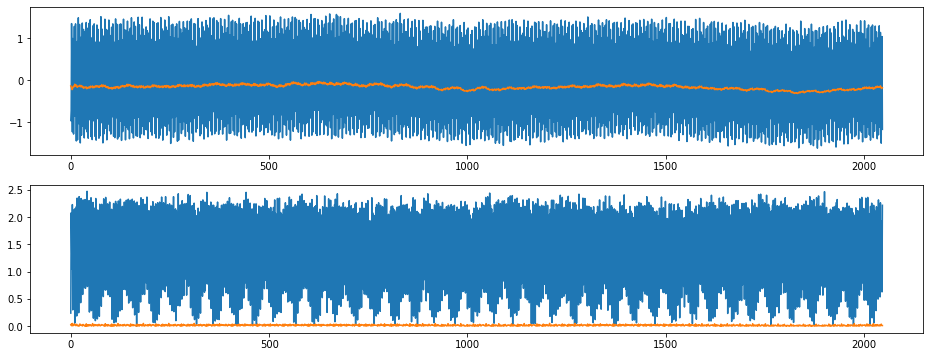

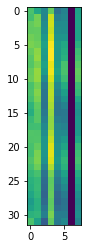

index:  317474
MAE:  0.9032062481442225
n_bunches       1227
bunch_index     3193
bunch_number    1145
Name: 11701490, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6620/instability_data/06620_Inst_B1H_Q7_20180428_21h48m14s.h5


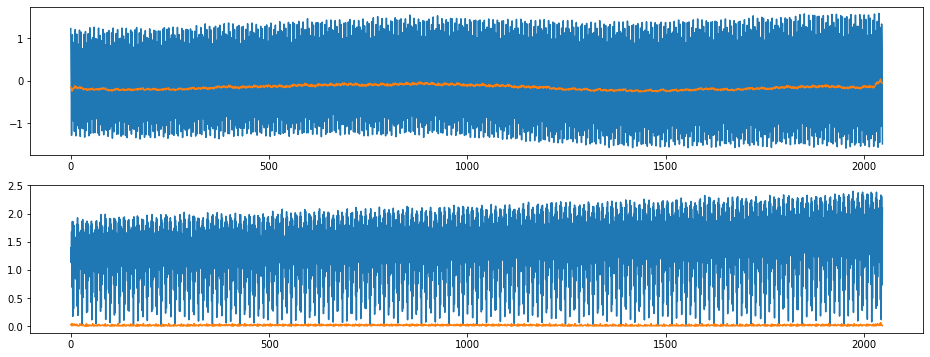

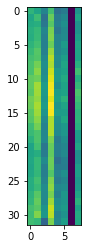

index:  156902
MAE:  0.9029035320105367
n_bunches       780
bunch_index     730
bunch_number    539
Name: 7209287, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181022_22h13m51s.h5


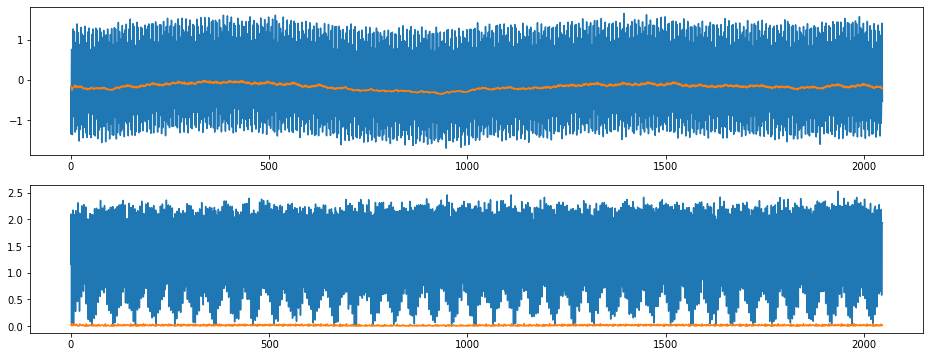

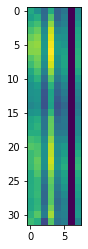

index:  174950
MAE:  0.9028107358400226
n_bunches        987
bunch_index     3170
bunch_number     889
Name: 10416615, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6929/instability_data/06929_Inst_B1H_Q7_20180716_05h52m14s.h5


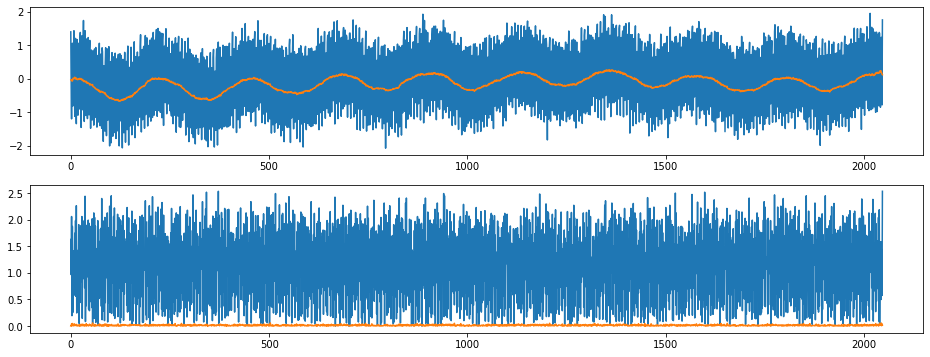

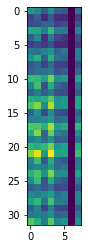

index:  172879
MAE:  0.9025918278403303
n_bunches       1868
bunch_index      372
bunch_number     188
Name: 597345, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_01h54m14s.h5


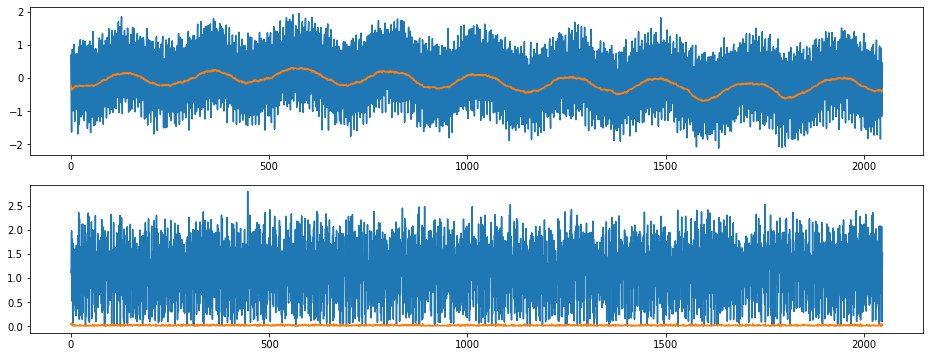

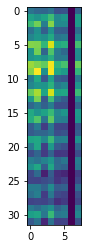

index:  179647
MAE:  0.902333224747758
n_bunches       2556
bunch_index     3358
bunch_number    2489
Name: 4343596, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6666/instability_data/06666_Inst_B1H_Q7_20180510_23h16m15s.h5


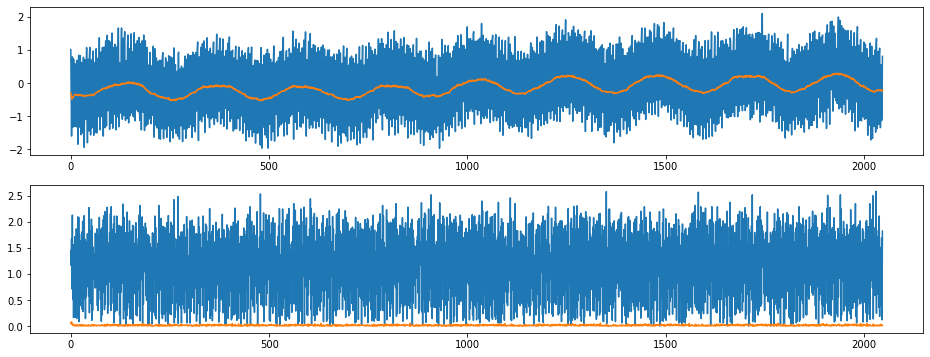

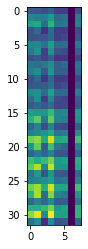

index:  315565
MAE:  0.9013068046497
n_bunches        924
bunch_index     1043
bunch_number     765
Name: 4227729, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7112/instability_data/07112_Inst_B1H_Q7_20180901_12h08m54s.h5


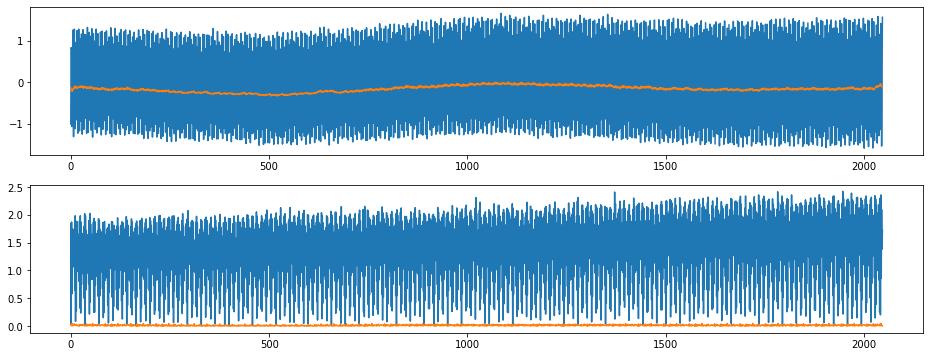

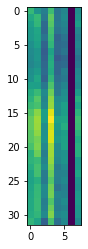

index:  317653
MAE:  0.9011811970911728
n_bunches       108
bunch_index     135
bunch_number     79
Name: 5994134, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7321/instability_data/07321_Inst_B1H_Q7_20181020_09h08m18s.h5


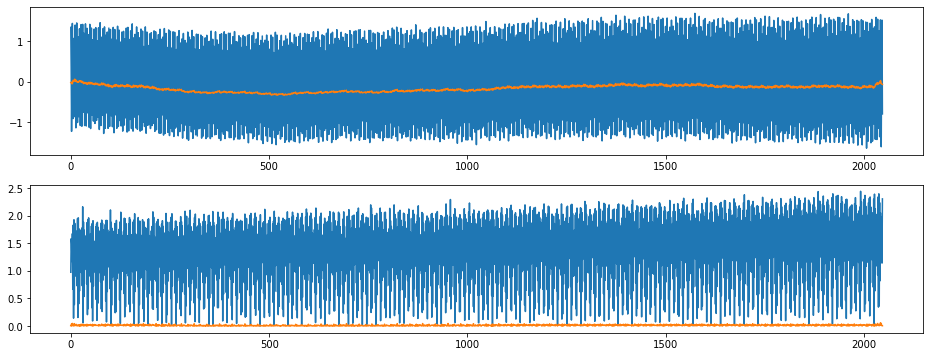

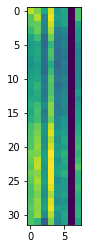

index:  112410
MAE:  0.9011626437341854
n_bunches       1068
bunch_index      227
bunch_number     121
Name: 6628935, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6741/instability_data/06741_Inst_B1H_Q7_20180530_10h08m16s.h5


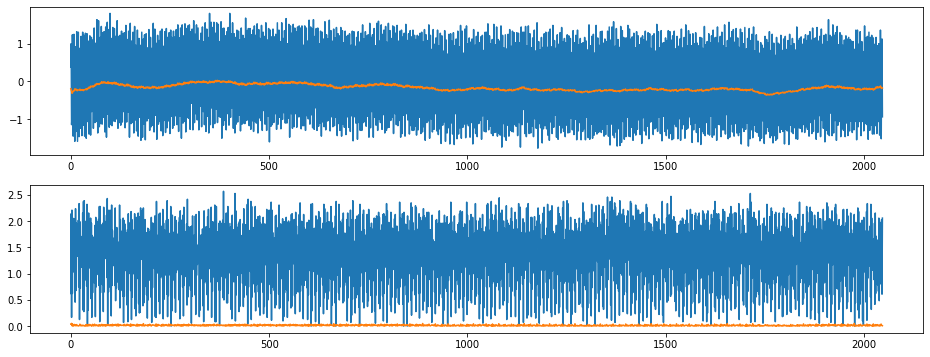

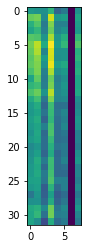

index:  319096
MAE:  0.9011566839232122
n_bunches       1068
bunch_index      214
bunch_number     127
Name: 10228211, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6957/instability_data/06957_Inst_B1H_Q7_20180721_22h33m33s.h5


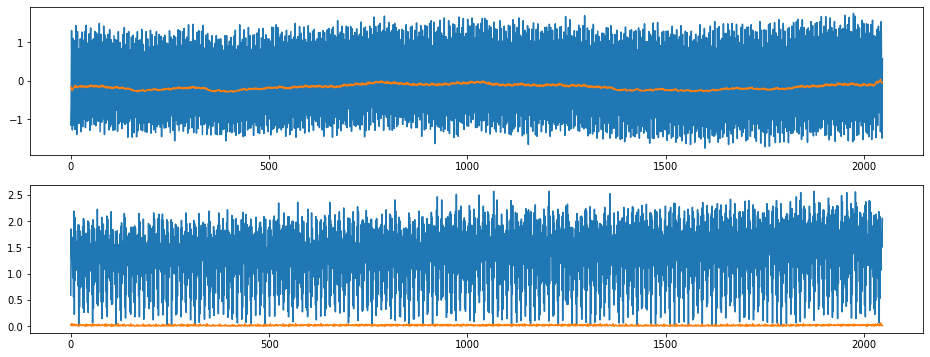

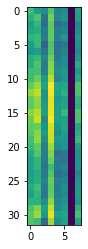

index:  111803
MAE:  0.9010805351581281
n_bunches       588
bunch_index     431
bunch_number    203
Name: 4037656, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6808/instability_data/06808_Inst_B1H_Q7_20180616_04h51m14s.h5


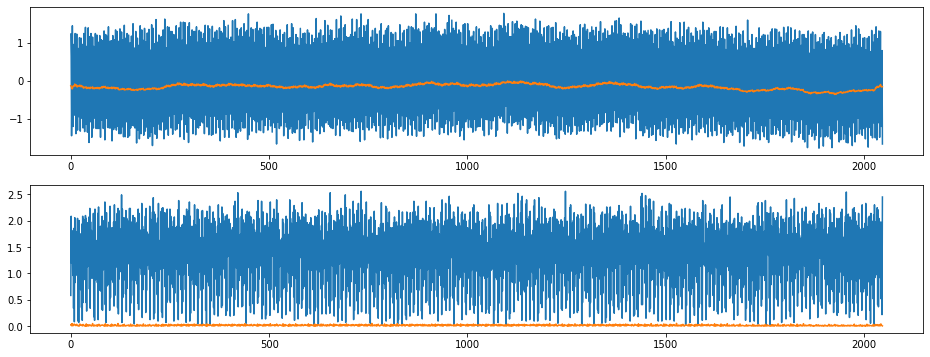

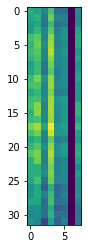

index:  109612
MAE:  0.9003255847674574
n_bunches       1916
bunch_index     1999
bunch_number    1094
Name: 5147125, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_18h45m15s.h5


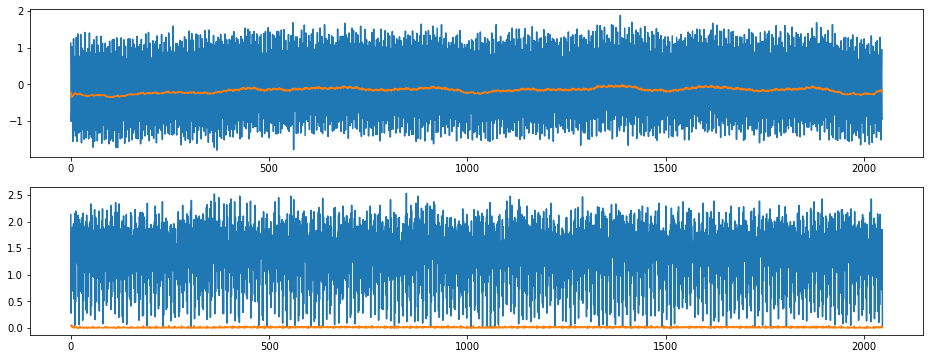

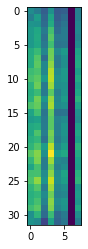

index:  176586
MAE:  0.90021146656321
n_bunches       1452
bunch_index     3132
bunch_number    1324
Name: 1448905, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_22h27m14s.h5


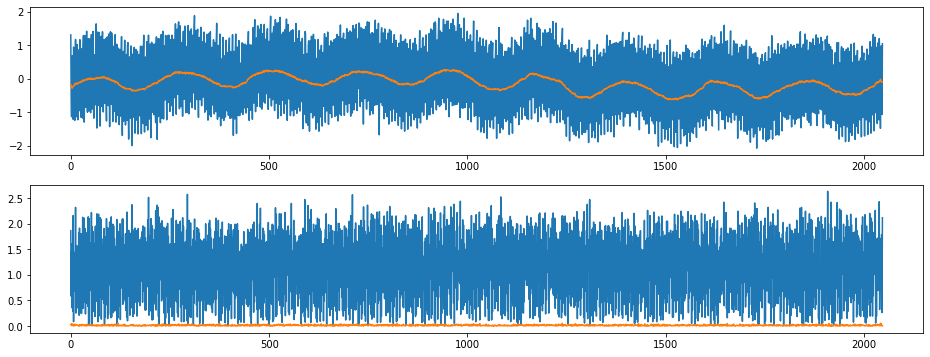

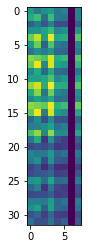

index:  109901
MAE:  0.9001160644152164
n_bunches       1868
bunch_index     3044
bunch_number    1630
Name: 1293793, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6371/instability_data/06371_Inst_B1H_Q7_20171110_12h02m14s.h5


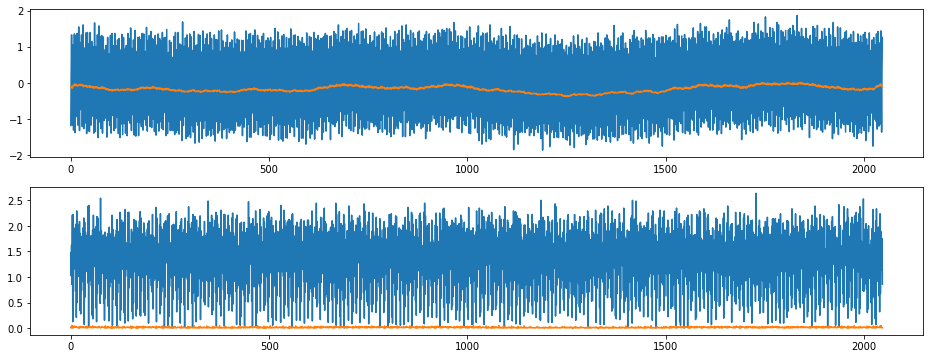

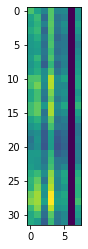

index:  82155
MAE:  0.8999909191042748
n_bunches       110
bunch_index     403
bunch_number     65
Name: 2082646, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/instability_data/06984_Inst_B1H_Q7_20180726_20h21m14s.h5


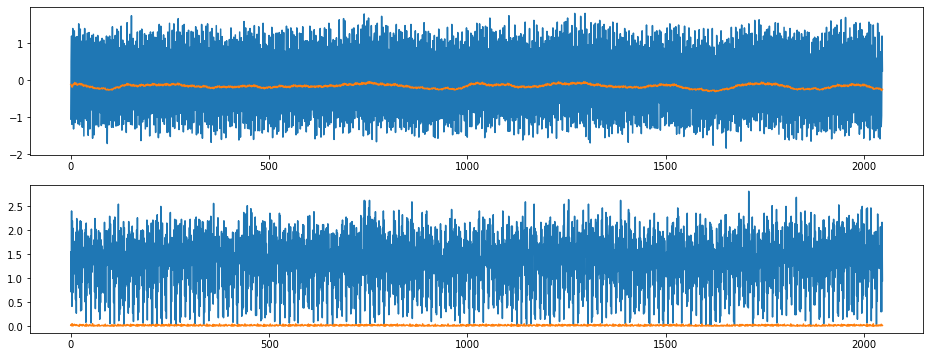

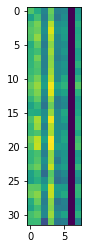

index:  197211
MAE:  0.8999119815943479
n_bunches       396
bunch_index     249
bunch_number     42
Name: 6736154, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_18h52m56s.h5


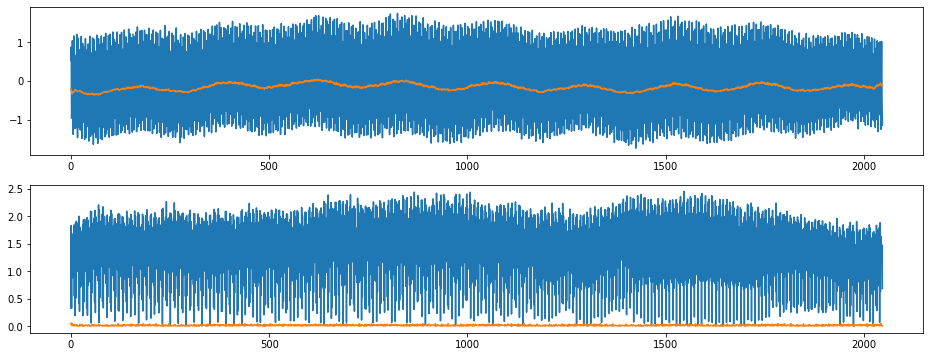

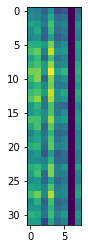

index:  312610
MAE:  0.8993984858775451
n_bunches       987
bunch_index     495
bunch_number    161
Name: 2602324, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_22h26m14s.h5


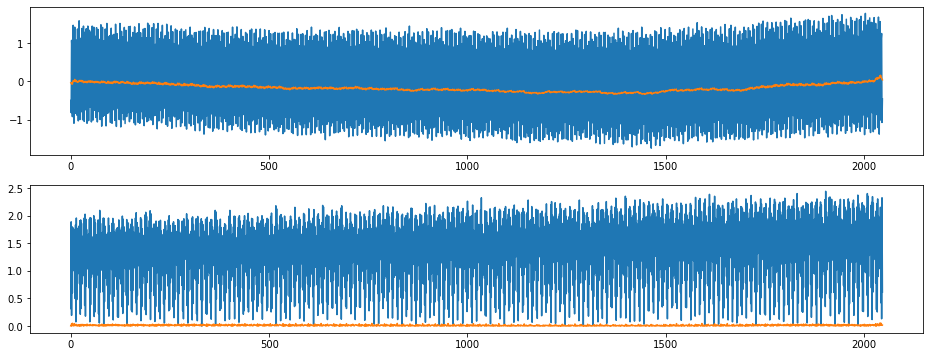

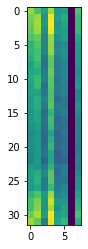

index:  173004
MAE:  0.899302630271038
n_bunches        603
bunch_index     3096
bunch_number     555
Name: 8542699, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6614/instability_data/06614_Inst_B1H_Q7_20180426_06h49m14s.h5


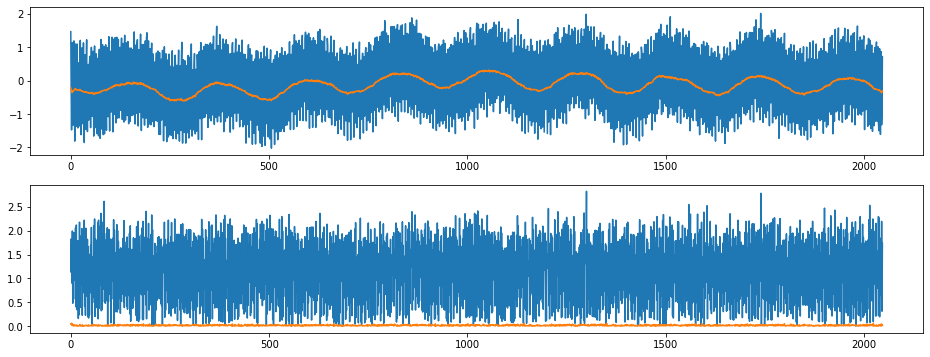

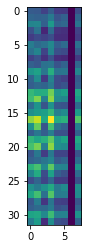

index:  107453
MAE:  0.899013309346
n_bunches       120
bunch_index     389
bunch_number     75
Name: 10501480, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7349/instability_data/07349_Inst_B1H_Q7_20181025_14h20m42s.h5


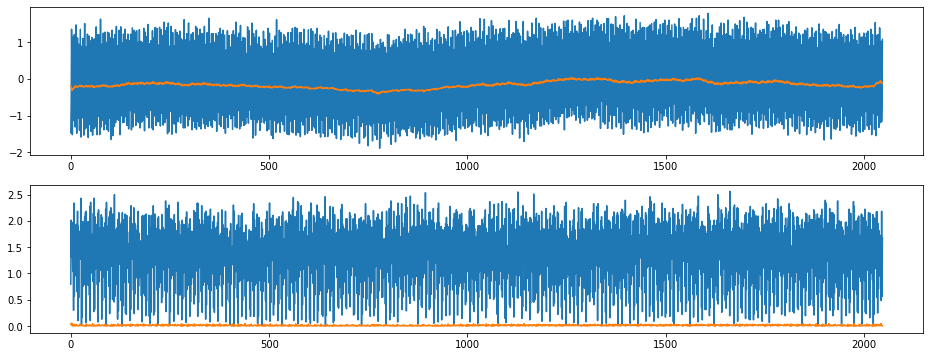

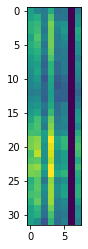

index:  112327
MAE:  0.8987646800917163
n_bunches       428
bunch_index     666
bunch_number    359
Name: 9937171, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6274/instability_data/06274_Inst_B1H_Q7_20171005_18h49m13s.h5


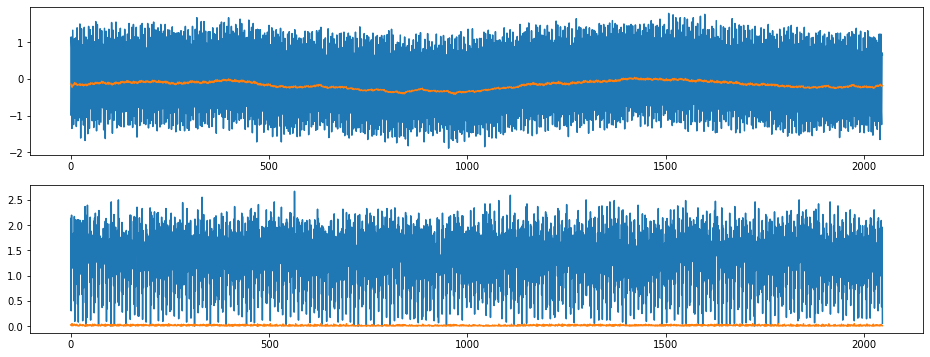

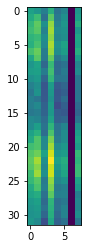

index:  114485
MAE:  0.898449466911849
n_bunches       1868
bunch_index     1060
bunch_number     563
Name: 3784361, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6337/instability_data/06337_Inst_B1H_Q7_20171027_07h20m14s.h5


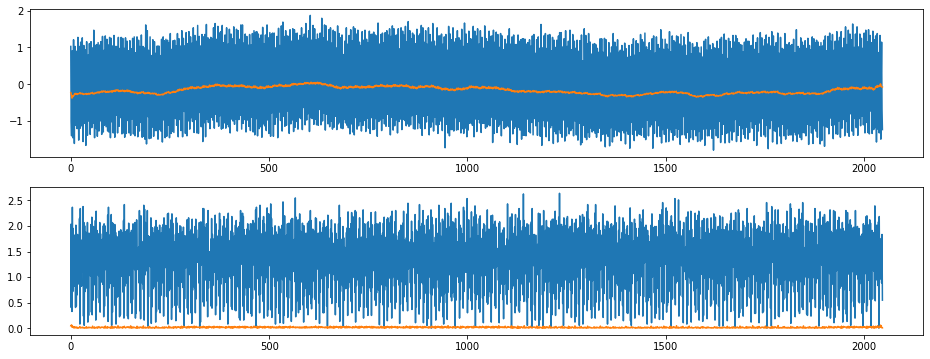

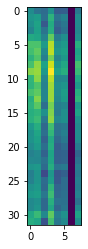

index:  107860
MAE:  0.8982477132737746
n_bunches       733
bunch_index     148
bunch_number     29
Name: 8380238, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7485/instability_data/07485_Inst_B1H_Q7_20181129_21h11m14s.h5


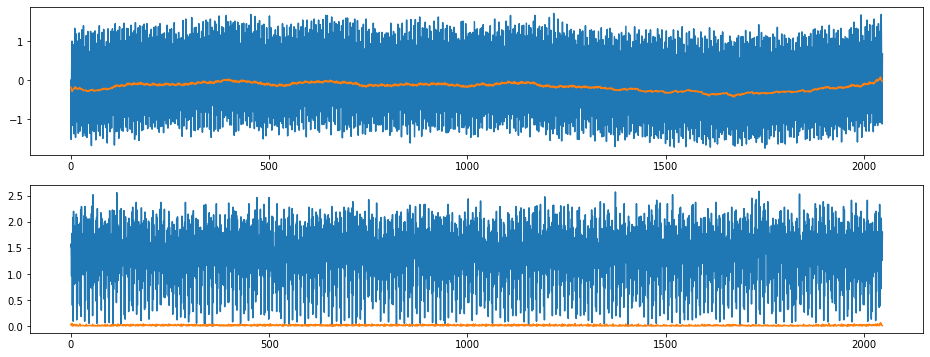

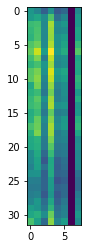

index:  109945
MAE:  0.8982101011954668
n_bunches       1887
bunch_index     2232
bunch_number    1268
Name: 4371711, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180516_21h20m15s.h5


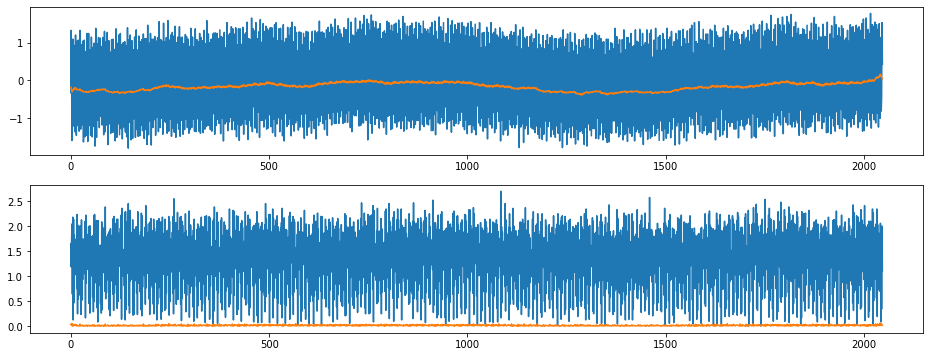

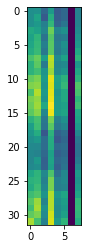

index:  312961
MAE:  0.8981720005048369
n_bunches       396
bunch_index     459
bunch_number    320
Name: 8940489, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7328/instability_data/07328_Inst_B1H_Q7_20181021_21h54m35s.h5


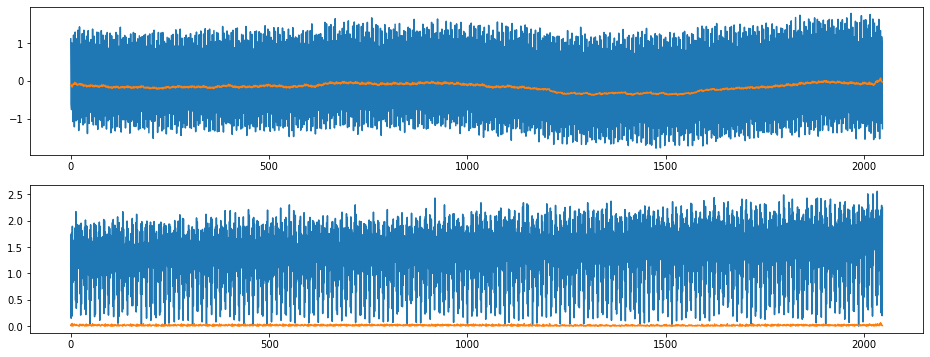

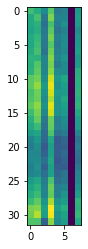

index:  408080
MAE:  0.8979824558292959
n_bunches        987
bunch_index     2056
bunch_number     591
Name: 3312829, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_04h12m34s.h5


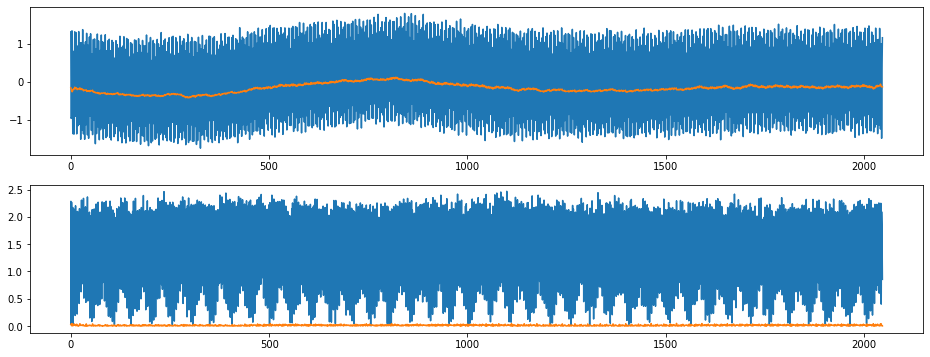

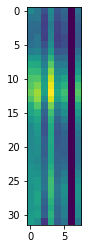

In [38]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()